### Code Hist.

 - CODE  
    &ensp; : KDHC - Regression - LGBM  

  - DATE  
    &ensp; 2023-12-06 Created  
    &ensp; 2023-12-07 Lab Updated  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; 1) 공통코드 모듈 사용  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; 2)    
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; 3)   
    
 - DESC  
    &ensp; : Model Analysis - 한국지역난방공사 청주지역 열판매량  
    &emsp; 1) 결측치가 없어서, 그대로 사용  
    &emsp;&ensp;&ensp; (Crawl Code 없음)   
    &emsp; 2)  

 - DATA  
    &emsp; <"Input">  
    1) None (Input Dataset)  
    &emsp;- Period :   
    &emsp;- Interval : 

    &emsp; <"Output">  
    1) -  
    &emsp;- Columns :   
    &emsp;- Period :   
    &emsp;- Interval :  
    
 - Related Link  
    &ensp; 1) XGBoost  
    &ensp;&ensp; https://nicola-ml.tistory.com/99   
    &ensp; 2) XGBoost  
    &ensp;&ensp; https://magoker.tistory.com/106   
    &ensp; 3) Pandas 특정 행  
    &ensp;&ensp; https://www.freecodecamp.org/korean/news/untitled/  

# 01. Code

## 01-01. Init

### 01-01-01. Init_Module Import

In [1]:
#region Basic_Import
## Basic
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import random
from pandas import DataFrame, Series

## Datetime
import time
import datetime as dt
from datetime import datetime, date, timedelta

from glob import glob
import requests
import json

## 시각화
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 8]

from scipy import stats

## TSNE
from sklearn.datasets import load_digits
from sklearn.manifold import TSNE

## 정규화
from sklearn.preprocessing import MinMaxScaler, StandardScaler

## Modeling, Model Training
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

## Model 평가
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score   # model.score   

## Excel/CSV
import openpyxl, xlrd

import urllib
from urllib.request import urlopen
from urllib.parse import urlencode, unquote, quote_plus

from selenium import webdriver
from selenium.webdriver.chrome.service import Service

from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup

## Init.
pd.options.display.float_format = '{:.10f}'.format
#endregion Basic_Import

In [2]:
## Import_DL
str_tar = "tf"
## For Torch
if str_tar == "torch":
    import torch
    import torch.nn as nn
    from torch.nn.utils import weight_norm
    print("Torch Imported")
## For TF
elif str_tar == "tf":
    import tensorflow as tf
    import tensorflow_addons as tfa
    print("Tensorflow Imported")
else:
    print("Error : Cannot be used except for Keywords")
    print(" : torch / tf")

Tensorflow Imported


In [3]:
# !pip install lightgbm

## LGBM
import lightgbm as lgbm
from lightgbm import LGBMRegressor

In [4]:
## Import_Local (현재 프로그램에서 미사용)
from DEV_Common_Data_Analysis import print_desc_statistic
from DEV_Common_Data_Datetime import create_col_ymdhm, create_col_datetime, create_df_dt, conv_midnight_24to00, create_col_weekdays #, validate_date, list_invalidDate, calc_df_dt
from DEV_Common_Data_Preprocessing import resample_by_last, find_outlier_Usages, del_outlier_Usages
from DEV_Common_Data_Visualization import visualization_df
from DEV_KASI_Holiday import KASI_holiDay, KASI_restDay, KASI_anniDay
from DEV_KMA_Weather_ASOS import KMA_ASOS_DATA
from DEV_KDHC_Usage import KDHC_HEAT_Usage

### 01-01-02. Config (Directory, Params)

In [5]:
## Init_config
SEED = 42

np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = "1"
random.seed(SEED)

In [6]:
## Define Todate str
str_now_ymd = pd.datetime.now().date()
str_now_y = pd.datetime.now().year
str_now_m = pd.datetime.now().month
str_now_d = pd.datetime.now().day
str_now_hr = pd.datetime.now().hour
str_now_min = pd.datetime.now().minute

print(pd.datetime.now())
print(str(str_now_y) + " / " + str(str_now_m)  + " / " + str(str_now_d))
print(str(str_now_hr) + " : " + str(str_now_min))

2023-12-26 02:34:02.979331
2023 / 12 / 26
2 : 34


## 01-02. Data Load (df_raw)

### 01-02-01. KDHC Heat Usage

In [7]:
# Define data root directory
str_dir_kdhcHeat = "./data_Energy_KDHC_National_Heat/"
print(os.listdir(str_dir_kdhcHeat))

## CSV read
df_kdhc_cj = pd.read_csv(str_dir_kdhcHeat + 'KDHC_HEAT_CHEONGJU_2010_2021_1st_Check.csv')
df_kdhc_cj = df_kdhc_cj.rename(columns = {"HEAT_SELL_DATE" : "METER_DATE"})
df_kdhc_cj["METER_DATE"] = pd.to_datetime(df_kdhc_cj["METER_DATE"])
print(df_kdhc_cj.info())
df_kdhc_cj

['KDHC_COMB_HEAT-CJ_ASOS_KASI_2010-2023.csv', 'KDHC_COMB_HEATxWEATHER_2019-2022.csv', 'KDHC_COMB_HEATxWEATHER_2019-2022_complete_analysis.csv', 'KDHC_COMB_HEATxWEATHER_2019-2022_linearReg.csv', 'KDHC_COMB_HEATxWEATHER_2019-2022_mean_imp.csv', 'KDHC_COMB_KANGNAMHEATxWEATHER_2019-2022.csv', 'KDHC_HEAT', 'KDHC_HEAT.zip', 'KDHC_HEAT_CHEONGJU_2010_2021.csv', 'KDHC_HEAT_CHEONGJU_2010_2021_1st_Check.csv', 'KDHC_HEAT_SEJONG_2014_2018.csv', 'KDHC_HEAT_SEJONG_2014_2018_1st_Check.csv', 'KDHC_NATIONAL_HEAT_hr.csv', 'KDHC_NATIONAL_HEAT_RAW_hr.csv']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105192 entries, 0 to 105191
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   METER_DATE       105192 non-null  datetime64[ns]
 1   DAY_OF_THE_WEEK  105192 non-null  object        
 2   HOUR             105192 non-null  int64         
 3   CHEONGJU         105192 non-null  float64       
 4   YEAR             10

METER_DATE DAY_OF_THE_WEEK  HOUR       CHEONGJU  YEAR  MONTH  \
0      2010-01-01 01:00:00               금     1 178.0000000000  2010      1   
1      2010-01-01 02:00:00               금     2 170.0000000000  2010      1   
2      2010-01-01 03:00:00               금     3 165.0000000000  2010      1   
3      2010-01-01 04:00:00               금     4 161.0000000000  2010      1   
4      2010-01-01 05:00:00               금     5 162.0000000000  2010      1   
...                    ...             ...   ...            ...   ...    ...   
105187 2021-12-31 20:00:00               금    20 217.0000000000  2021     12   
105188 2021-12-31 21:00:00               금    21 221.0000000000  2021     12   
105189 2021-12-31 22:00:00               금    22 217.0000000000  2021     12   
105190 2021-12-31 23:00:00               금    23 214.0000000000  2021     12   
105191 2022-01-01 00:00:00               금     0 207.0000000000  2022      1   

        DAY  
0         1  
1         1  
2         1  
3         1  
4         1  
...     ...  
105187   31  
105188   31  
105189   31  
105190   31  
105191    1  

[105192 rows x 7 columns]

### 01-02-02. KMA ASOS

In [8]:
# Define data root directory
str_dir_ASOS = "./data_KMA_ASOS/"
print(os.listdir(str_dir_ASOS))

## CSV read
df_asos = pd.read_csv(str_dir_ASOS + 'KMA_ASOS_131_2010-2023_Cleansed_HR.csv'
                      , index_col = 0)
df_asos["METER_DATE"] = pd.to_datetime(df_asos["METER_DATE"])
print(df_asos.info())
df_asos

['ASOS_108_2010.csv', 'ASOS_108_2010_D.csv', 'ASOS_108_2011.csv', 'ASOS_108_2011_D.csv', 'ASOS_108_2012.csv', 'ASOS_108_2012_D.csv', 'ASOS_108_2013.csv', 'ASOS_108_2013_D.csv', 'ASOS_108_2014.csv', 'ASOS_108_2014_D.csv', 'ASOS_108_2015.csv', 'ASOS_108_2015_D.csv', 'ASOS_108_2016.csv', 'ASOS_108_2016_D.csv', 'ASOS_108_2017.csv', 'ASOS_108_2017_D.csv', 'ASOS_108_2018.csv', 'ASOS_108_2018_D.csv', 'ASOS_108_2019.csv', 'ASOS_108_2019_D.csv', 'ASOS_108_2020.csv', 'ASOS_108_2020_D.csv', 'ASOS_108_2021.csv', 'ASOS_108_2021_D.csv', 'ASOS_108_2022.csv', 'ASOS_108_2022_D.csv', 'ASOS_108_2023.csv', 'ASOS_108_2023_D.csv', 'ASOS_119_2010.csv', 'ASOS_119_2010_D.csv', 'ASOS_119_2011.csv', 'ASOS_119_2011_D.csv', 'ASOS_119_2012.csv', 'ASOS_119_2012_D.csv', 'ASOS_119_2013.csv', 'ASOS_119_2013_D.csv', 'ASOS_119_2014.csv', 'ASOS_119_2014_D.csv', 'ASOS_119_2015.csv', 'ASOS_119_2015_D.csv', 'ASOS_119_2016.csv', 'ASOS_119_2016_D.csv', 'ASOS_119_2017.csv', 'ASOS_119_2017_D.csv', 'ASOS_119_2018.csv', 'ASOS_119_

METER_DATE  temp_outdoor  temp_dew_point   temp_ground  \
0    2010-01-01 00:00:00 -9.0000000000  -18.0000000000 -8.0000000000   
1    2010-01-01 01:00:00 -9.0000000000  -17.3000000000 -7.0000000000   
2    2010-01-01 02:00:00 -9.3000000000  -15.6000000000 -6.1000000000   
3    2010-01-01 03:00:00 -9.2000000000  -15.5000000000 -6.0000000000   
4    2010-01-01 04:00:00 -9.7000000000  -15.0000000000 -7.5000000000   
...                  ...           ...             ...           ...   
5275 2023-08-08 19:00:00 30.6000000000   25.1000000000 30.1000000000   
5276 2023-08-08 20:00:00 30.8000000000   24.4000000000 29.5000000000   
5277 2023-08-08 21:00:00 31.3000000000   22.8000000000 29.1000000000   
5278 2023-08-08 22:00:00 31.0000000000   22.5000000000 28.6000000000   
5279 2023-08-08 23:00:00 30.5000000000   22.6000000000 28.2000000000   

          humidity     rainfall     snowfall  snowfall_3hr   wind_speed  \
0    48.0000000000 0.0000000000 0.0000000000  0.0000000000 0.9000000000   
1    51.0000000000 0.0000000000 0.0000000000  0.0000000000 1.1000000000   
2    60.0000000000 0.0000000000 0.0000000000  0.0000000000 0.9000000000   
3    60.0000000000 0.0000000000 0.0000000000  0.0000000000 0.2000000000   
4    65.0000000000 0.0000000000 0.0000000000  0.0000000000 0.5000000000   
...            ...          ...          ...           ...          ...   
5275 73.0000000000 0.0000000000 0.0000000000  0.0000000000 1.3000000000   
5276 69.0000000000 0.0000000000 0.0000000000  0.0000000000 1.1000000000   
5277 61.0000000000 0.0000000000 0.0000000000  0.0000000000 1.6000000000   
5278 61.0000000000 0.0000000000 0.0000000000  0.0000000000 2.1000000000   
5279 63.0000000000 0.0000000000 0.0000000000  0.0000000000 1.4000000000   

      wind_direction  pressure_vapor   pressure_area    pressure_sea  \
0     320.0000000000    1.5000000000 1016.2000000000 1023.6000000000   
1     250.0000000000    1.6000000000 1016.4000000000 1023.8000000000   
2     340.0000000000    1.8000000000 1016.6000000000 1024.0000000000   
3       0.0000000000    1.8000000000 1016.9000000000 1024.3000000000   
4     340.0000000000    1.9000000000 1016.5000000000 1023.9000000000   
...              ...             ...             ...             ...   
5275   50.0000000000   31.9000000000  995.0000000000 1001.5000000000   
5276   20.0000000000   30.6000000000  995.5000000000 1002.0000000000   
5277   70.0000000000   27.7000000000  995.9000000000 1002.4000000000   
5278   70.0000000000   27.2000000000  995.9000000000 1002.4000000000   
5279   70.0000000000   27.4000000000  996.3000000000 1002.8000000000   

         sunshine  solar_radiation  cloud_total  cloud_midlow    visual_range  
0    0.0000000000     0.0000000000 0.0000000000  0.0000000000 1800.0000000000  
1    0.0000000000     0.0000000000 0.0000000000  0.0000000000    0.0000000000  
2    0.0000000000     0.0000000000 0.0000000000  0.0000000000    0.0000000000  
3    0.0000000000     0.0000000000 7.0000000000  7.0000000000 1800.0000000000  
4    0.0000000000     0.0000000000 2.0000000000  2.0000000000 1800.0000000000  
...           ...              ...          ...           ...             ...  
5275 0.0000000000     0.2800000000 8.0000000000  8.0000000000 3628.0000000000  
5276 0.0000000000     0.0100000000 8.0000000000  8.0000000000 5000.0000000000  
5277 0.0000000000     0.0000000000 7.0000000000  7.0000000000 5000.0000000000  
5278 0.0000000000     0.0000000000 7.0000000000  7.0000000000 5000.0000000000  
5279 0.0000000000     0.0000000000 7.0000000000  1.0000000000 5000.0000000000  

[119230 rows x 18 columns]

### 01-02-03. KASI

In [9]:
# Define data root directory
str_dir_KASI = "./data_Date_KASI/"
# print(os.listdir(str_dir_KASI))

## CSV read
df_kasi = pd.read_csv(str_dir_KASI + 'KASI_04-01_holiDay_distAdded_hr.csv')
df_kasi = df_kasi.rename(columns = {"DATETIME" : "METER_DATE"})
df_kasi = df_kasi[['METER_DATE', 'YEAR', 'MONTH', 'DAY', 'code_day_of_the_week', 'dist_from_holiday'
                   , 'HOUR', 'rest_YN']]
print(df_kasi.info())
df_kasi

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122690 entries, 0 to 122689
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   METER_DATE            122690 non-null  object
 1   YEAR                  122690 non-null  int64 
 2   MONTH                 122690 non-null  int64 
 3   DAY                   122690 non-null  int64 
 4   code_day_of_the_week  122690 non-null  int64 
 5   dist_from_holiday     122690 non-null  object
 6   HOUR                  122690 non-null  int64 
 7   rest_YN               122690 non-null  object
dtypes: int64(5), object(3)
memory usage: 7.5+ MB
None


METER_DATE  YEAR  MONTH  DAY  code_day_of_the_week  \
0       2010-01-01 00:00:00  2010      1    1                     4   
1       2010-01-01 01:00:00  2010      1    1                     4   
2       2010-01-01 02:00:00  2010      1    1                     4   
3       2010-01-01 03:00:00  2010      1    1                     4   
4       2010-01-01 04:00:00  2010      1    1                     4   
...                     ...   ...    ...  ...                   ...   
122685  2023-12-30 20:00:00  2023     12   30                     5   
122686  2023-12-30 21:00:00  2023     12   30                     5   
122687  2023-12-30 22:00:00  2023     12   30                     5   
122688  2023-12-30 23:00:00  2023     12   30                     5   
122689  2023-12-31 00:00:00  2023     12   31                     6   

       dist_from_holiday  HOUR rest_YN  
0                      0     0       1  
1                     23     1       0  
2                     22     2       0  
3                     21     3       0  
4                     20     4       0  
...                  ...   ...     ...  
122685                 0    20       1  
122686                 0    21       1  
122687                 0    22       1  
122688                 0    23       1  
122689                 0     0       1  

[122690 rows x 8 columns]

### 01-02-04. KorEx_Traffic

In [10]:
# # Define data root directory
# str_dir_KorEx = "./data_korEx_Traffic/"

# ## CSV read
# df_traffic = pd.read_csv(str_dir_KorEx + 'KorEx_DATA_Traffic_CJ_2019-2023_Final.csv'
#                       , index_col = 0)
# df_traffic

In [11]:
# Define data root directory
str_dir_KorEx = "./data_korEx_TCS_Traffic/"

## CSV read
df_traffic = pd.read_csv(str_dir_KorEx + 'KorEx_DATA_Traffic_CJ_2010-2023.csv'
                      , index_col = 0)
df_traffic

METER_DATE  YEAR  MONTH  DAY  code_day_of_the_week  HOUR  \
0       2010-01-01 00:00:00  2010      1    1                     4     0   
1       2010-01-01 01:00:00  2010      1    1                     4     1   
2       2010-01-01 02:00:00  2010      1    1                     4     2   
3       2010-01-01 03:00:00  2010      1    1                     4     3   
4       2010-01-01 04:00:00  2010      1    1                     4     4   
...                     ...   ...    ...  ...                   ...   ...   
121963  2023-11-30 19:00:00  2023     11   30                     3    19   
121964  2023-11-30 20:00:00  2023     11   30                     3    20   
121965  2023-11-30 21:00:00  2023     11   30                     3    21   
121966  2023-11-30 22:00:00  2023     11   30                     3    22   
121967  2023-11-30 23:00:00  2023     11   30                     3    23   

          TRAFFIC_IN_1  TRAFFIC_IN_2   TRAFFIC_OUT_1  TRAFFIC_OUT_2  
0       211.0000000000 13.0000000000  267.0000000000  19.0000000000  
1       159.0000000000  7.0000000000  188.0000000000   4.0000000000  
2       118.0000000000  8.0000000000   94.0000000000   9.0000000000  
3       209.0000000000 14.0000000000  170.0000000000  13.0000000000  
4       956.0000000000 22.0000000000  623.0000000000  16.0000000000  
...                ...           ...             ...            ...  
121963  543.0000000000  4.0000000000  527.0000000000  13.0000000000  
121964  105.0000000000 15.0000000000  173.0000000000  14.0000000000  
121965   73.0000000000 17.0000000000   72.0000000000  23.0000000000  
121966 1616.0000000000 49.0000000000 1523.0000000000  53.0000000000  
121967 1206.0000000000 50.0000000000 1153.0000000000  66.0000000000  

[120384 rows x 10 columns]

### 01-02-05. MOIS_Population

In [12]:
str_dir_MOIS = "./data_MOIS_Population/"
df_population = pd.read_csv(str_dir_MOIS + 'MOIS_CHEONGJU_201001_202311_Monthly.csv'
                            , encoding = 'cp949')
df_population.info()
# df_population['POPULATION_TOTAL'] = int(df_population['POPULATION_TOTAL'])
# df_population['POPULATION_MALE'] = int(df_population['POPULATION_MALE'])
# df_population['POPULATION_FEMALE'] = int(df_population['PPULATION_FEMALE'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   YEAR               167 non-null    int64
 1   MONTH              167 non-null    int64
 2   POPULATION_TOTAL   167 non-null    int64
 3   POPULATION_MALE    167 non-null    int64
 4   POPULATION_FEMALE  167 non-null    int64
dtypes: int64(5)
memory usage: 6.6 KB


### 01-02-04. df_dt

In [13]:
print("date_kdhc_cj")
date_kdhc_cj = pd.to_datetime(df_kdhc_cj["METER_DATE"])
dt_kdhc_cj_start = date_kdhc_cj.min()
dt_kdhc_cj_end = date_kdhc_cj.max()
print(dt_kdhc_cj_start)
print(dt_kdhc_cj_end)

print("date_asos")
date_asos = pd.to_datetime(df_asos["METER_DATE"])
date_asos_start = date_asos.min()
date_asos_end = date_asos.max()
print(date_asos_start)
print(date_asos_end)

print("date_kasi")
date_kasi = pd.to_datetime(df_kasi["METER_DATE"])
date_kasi_start = date_kasi.min()
date_kasi_end = date_kasi.max()
print(date_kasi_start)
print(date_kasi_end)

print("date_traffic")
date_traffic = pd.to_datetime(df_traffic["METER_DATE"])
date_traffic_start = date_traffic.min()
date_traffic_end = date_traffic.max()
print(date_traffic_start)
print(date_traffic_end)

## 얘는 년월임
print("date_population")
# date_population = pd.to_datetime(df_population["METER_DATE"])
# date_population_start = date_population.min()
# date_population_end = date_population.max()
# print(date_population_start)
# print(date_population_end)

date_kdhc_cj
2010-01-01 01:00:00
2022-01-01 00:00:00
date_asos
2010-01-01 00:00:00
2023-08-08 23:00:00
date_kasi
2010-01-01 00:00:00
2023-12-31 00:00:00
date_traffic
2010-01-01 00:00:00
2023-11-30 23:00:00
date_population


In [14]:
dt_start = max(dt_kdhc_cj_start, date_asos_start, date_kasi_start, date_traffic_start)
print(dt_start)
dt_end = min(dt_kdhc_cj_end, date_asos_end, date_kasi_end, date_traffic_end)
print(dt_end)

2010-01-01 01:00:00
2022-01-01 00:00:00


In [15]:
df_dt = pd.DataFrame()
df_dt = create_df_dt(df_dt, "METER_DATE", dt_start, dt_end, "1H")
df_dt

METER_DATE day_of_the_week  YEAR  MONTH  DAY  HOUR  MINUTE  \
0      2010-01-01 01:00:00          Friday  2010      1    1     1       0   
1      2010-01-01 02:00:00          Friday  2010      1    1     2       0   
2      2010-01-01 03:00:00          Friday  2010      1    1     3       0   
3      2010-01-01 04:00:00          Friday  2010      1    1     4       0   
4      2010-01-01 05:00:00          Friday  2010      1    1     5       0   
...                    ...             ...   ...    ...  ...   ...     ...   
105187 2021-12-31 20:00:00          Friday  2021     12   31    20       0   
105188 2021-12-31 21:00:00          Friday  2021     12   31    21       0   
105189 2021-12-31 22:00:00          Friday  2021     12   31    22       0   
105190 2021-12-31 23:00:00          Friday  2021     12   31    23       0   
105191 2022-01-01 00:00:00        Saturday  2022      1    1     0       0   

        code_day_of_the_week  
0                          4  
1                          4  
2                          4  
3                          4  
4                          4  
...                      ...  
105187                     4  
105188                     4  
105189                     4  
105190                     4  
105191                     5  

[105192 rows x 8 columns]

## 01-03. Intergration

In [16]:
df_kdhc_cj = df_kdhc_cj[['METER_DATE', 'YEAR', 'MONTH', 'DAY'
                         , 'HOUR', 'CHEONGJU']]

df_kdhc_cj["METER_DATE"] = pd.to_datetime(df_kdhc_cj["METER_DATE"])
df_asos["METER_DATE"] = pd.to_datetime(df_asos["METER_DATE"])
df_kasi["METER_DATE"] = pd.to_datetime(df_kasi["METER_DATE"])
df_traffic["METER_DATE"] = pd.to_datetime(df_traffic["METER_DATE"])
df_dt["METER_DATE"] = pd.to_datetime(df_dt["METER_DATE"])

df_merge = pd.DataFrame()
df_merge = pd.merge(df_dt, df_kasi
                    , how = 'left', on = ['METER_DATE', 'YEAR', 'MONTH', 'DAY', 'code_day_of_the_week'
                                          , 'HOUR'])
df_merge = pd.merge(df_merge, df_asos
                    , how = 'left', on = ['METER_DATE'])

df_merge = pd.merge(df_merge, df_kdhc_cj
                    , how = 'left', on = ['METER_DATE', 'YEAR', 'MONTH', 'DAY'
                                          , 'HOUR'])
df_merge = pd.merge(df_merge, df_traffic
                    , how = 'left', on = ['METER_DATE', 'YEAR', 'MONTH', 'DAY', 'code_day_of_the_week'
                                          , 'HOUR'])
df_merge = pd.merge(df_merge, df_population
                    , how = 'left', on = ['YEAR', 'MONTH'])

df_merge.columns

Index(['METER_DATE', 'day_of_the_week', 'YEAR', 'MONTH', 'DAY', 'HOUR',
       'MINUTE', 'code_day_of_the_week', 'dist_from_holiday', 'rest_YN',
       'temp_outdoor', 'temp_dew_point', 'temp_ground', 'humidity', 'rainfall',
       'snowfall', 'snowfall_3hr', 'wind_speed', 'wind_direction',
       'pressure_vapor', 'pressure_area', 'pressure_sea', 'sunshine',
       'solar_radiation', 'cloud_total', 'cloud_midlow', 'visual_range',
       'CHEONGJU', 'TRAFFIC_IN_1', 'TRAFFIC_IN_2', 'TRAFFIC_OUT_1',
       'TRAFFIC_OUT_2', 'POPULATION_TOTAL', 'POPULATION_MALE',
       'POPULATION_FEMALE'],
      dtype='object')

In [17]:
## Export
df_merge.to_csv(str_dir_kdhcHeat + "KDHC_COMB_HEAT-CJ_ASOS_KASI_2010-2023.csv")

In [18]:
df_merge = pd.read_csv(str_dir_kdhcHeat + "KDHC_COMB_HEAT-CJ_ASOS_KASI_2010-2023.csv"
                       , index_col = 0)
df_raw = df_merge
df_raw

METER_DATE day_of_the_week  YEAR  MONTH  DAY  HOUR  MINUTE  \
0       2010-01-01 01:00:00          Friday  2010      1    1     1       0   
1       2010-01-01 02:00:00          Friday  2010      1    1     2       0   
2       2010-01-01 03:00:00          Friday  2010      1    1     3       0   
3       2010-01-01 04:00:00          Friday  2010      1    1     4       0   
4       2010-01-01 05:00:00          Friday  2010      1    1     5       0   
...                     ...             ...   ...    ...  ...   ...     ...   
109571  2021-12-31 20:00:00          Friday  2021     12   31    20       0   
109572  2021-12-31 21:00:00          Friday  2021     12   31    21       0   
109573  2021-12-31 22:00:00          Friday  2021     12   31    22       0   
109574  2021-12-31 23:00:00          Friday  2021     12   31    23       0   
109575  2022-01-01 00:00:00        Saturday  2022      1    1     0       0   

        code_day_of_the_week dist_from_holiday rest_YN  ...  cloud_midlow  \
0                          4                23       0  ...  0.0000000000   
1                          4                22       0  ...  0.0000000000   
2                          4                21       0  ...  7.0000000000   
3                          4                20       0  ...  2.0000000000   
4                          4                19       0  ...  0.0000000000   
...                      ...               ...     ...  ...           ...   
109571                     4                 4       0  ...  0.0000000000   
109572                     4                 3       0  ...  0.0000000000   
109573                     4                 2       0  ...  0.0000000000   
109574                     4                 1       0  ...  0.0000000000   
109575                     5                 0       1  ...  0.0000000000   

          visual_range       CHEONGJU    TRAFFIC_IN_1  TRAFFIC_IN_2  \
0         0.0000000000 178.0000000000  159.0000000000  7.0000000000   
1         0.0000000000 170.0000000000  118.0000000000  8.0000000000   
2      1800.0000000000 165.0000000000  209.0000000000 14.0000000000   
3      1800.0000000000 161.0000000000  956.0000000000 22.0000000000   
4      1800.0000000000 162.0000000000  954.0000000000 24.0000000000   
...                ...            ...             ...           ...   
109571 4622.0000000000 217.0000000000   49.0000000000 12.0000000000   
109572 4957.0000000000 221.0000000000  402.0000000000 54.0000000000   
109573 5188.0000000000 217.0000000000 1121.0000000000 93.0000000000   
109574 4003.0000000000 214.0000000000 1368.0000000000 56.0000000000   
109575 4145.0000000000 207.0000000000  154.0000000000  7.0000000000   

         TRAFFIC_OUT_1  TRAFFIC_OUT_2  POPULATION_TOTAL  POPULATION_MALE  \
0       188.0000000000   4.0000000000            644107           320741   
1        94.0000000000   9.0000000000            644107           320741   
2       170.0000000000  13.0000000000            644107           320741   
3       623.0000000000  16.0000000000            644107           320741   
4       772.0000000000  16.0000000000            644107           320741   
...                ...            ...               ...              ...   
109571   43.0000000000  24.0000000000            848482           427881   
109572  375.0000000000  58.0000000000            848482           427881   
109573  846.0000000000  53.0000000000            848482           427881   
109574 1033.0000000000  40.0000000000            848482           427881   
109575  161.0000000000   4.0000000000            848797           428057   

        POPULATION_FEMALE  
0                  323366  
1                  323366  
2                  323366  
3                  323366  
4                  323366  
...                   ...  
109571             420601  
109572             420601  
109573             420601  
109574             420601  
109575             420740  

[109576 rows x 35 columns]

## 01-04. Visualization & Remove Outlier

### 01-04-04. 변수형 정리

In [19]:
df_raw_temp = pd.DataFrame(df_raw)
df_raw_temp['METER_DATE'] = pd.to_datetime(df_raw_temp['METER_DATE'])

for i in range(0, len(df_raw_temp)):
    ## 중간에 Code화 되지 않은 rest_YN Data가 있다.
    if((str(df_raw_temp['rest_YN'].iloc[i]) == 'N') | (df_raw_temp['rest_YN'].iloc[i] == '0')):
        df_raw_temp['rest_YN'].iloc[i] = 0
    if((str(df_raw_temp['rest_YN'].iloc[i]) == 'Y') | (df_raw_temp['rest_YN'].iloc[i] == '1')):
        df_raw_temp['rest_YN'].iloc[i] = 1

    ## 중간에 이상하게 처리된 KASI Data가 있다.
    if((str(df_raw_temp['dist_from_holiday'].iloc[i]) == '제헌절')
        | (str(df_raw_temp['dist_from_holiday'].iloc[i]) == '한글날')):
        df_raw_temp['dist_from_holiday'].iloc[i] = 0
    
df_raw_temp['rest_YN'] = pd.to_numeric(df_raw_temp['rest_YN'])
df_raw_temp['rest_YN'] = df_raw_temp['rest_YN'].apply(pd.to_numeric)
# df_raw_temp['rest_YN'] = df_raw_temp['rest_YN'].astype('int32')
df_raw_temp['dist_from_holiday'] = df_raw_temp['dist_from_holiday'].apply(pd.to_numeric)
# df_raw_temp['dist_from_holiday'] = df_raw_temp['dist_from_holiday'].astype("int64")

In [20]:
print(df_raw_temp.columns)
print(df_raw_temp.info())

df_raw_temp = df_raw_temp.dropna()

print(df_raw_temp.info())

Index(['METER_DATE', 'day_of_the_week', 'YEAR', 'MONTH', 'DAY', 'HOUR',
       'MINUTE', 'code_day_of_the_week', 'dist_from_holiday', 'rest_YN',
       'temp_outdoor', 'temp_dew_point', 'temp_ground', 'humidity', 'rainfall',
       'snowfall', 'snowfall_3hr', 'wind_speed', 'wind_direction',
       'pressure_vapor', 'pressure_area', 'pressure_sea', 'sunshine',
       'solar_radiation', 'cloud_total', 'cloud_midlow', 'visual_range',
       'CHEONGJU', 'TRAFFIC_IN_1', 'TRAFFIC_IN_2', 'TRAFFIC_OUT_1',
       'TRAFFIC_OUT_2', 'POPULATION_TOTAL', 'POPULATION_MALE',
       'POPULATION_FEMALE'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Int64Index: 109576 entries, 0 to 109575
Data columns (total 35 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   METER_DATE            109576 non-null  datetime64[ns]
 1   day_of_the_week       109576 non-null  object        
 2   YEAR                  109576 no

In [21]:
df_raw = df_raw_temp.dropna()

### 01-04-01. Visualization (1차)

In [22]:
## Date의 형식을 datetime으로 변경
date = pd.to_datetime(df_raw['METER_DATE'])
date

0        2010-01-01 01:00:00
1        2010-01-01 02:00:00
2        2010-01-01 03:00:00
3        2010-01-01 04:00:00
4        2010-01-01 05:00:00
                 ...        
109571   2021-12-31 20:00:00
109572   2021-12-31 21:00:00
109573   2021-12-31 22:00:00
109574   2021-12-31 23:00:00
109575   2022-01-01 00:00:00
Name: METER_DATE, Length: 103607, dtype: datetime64[ns]

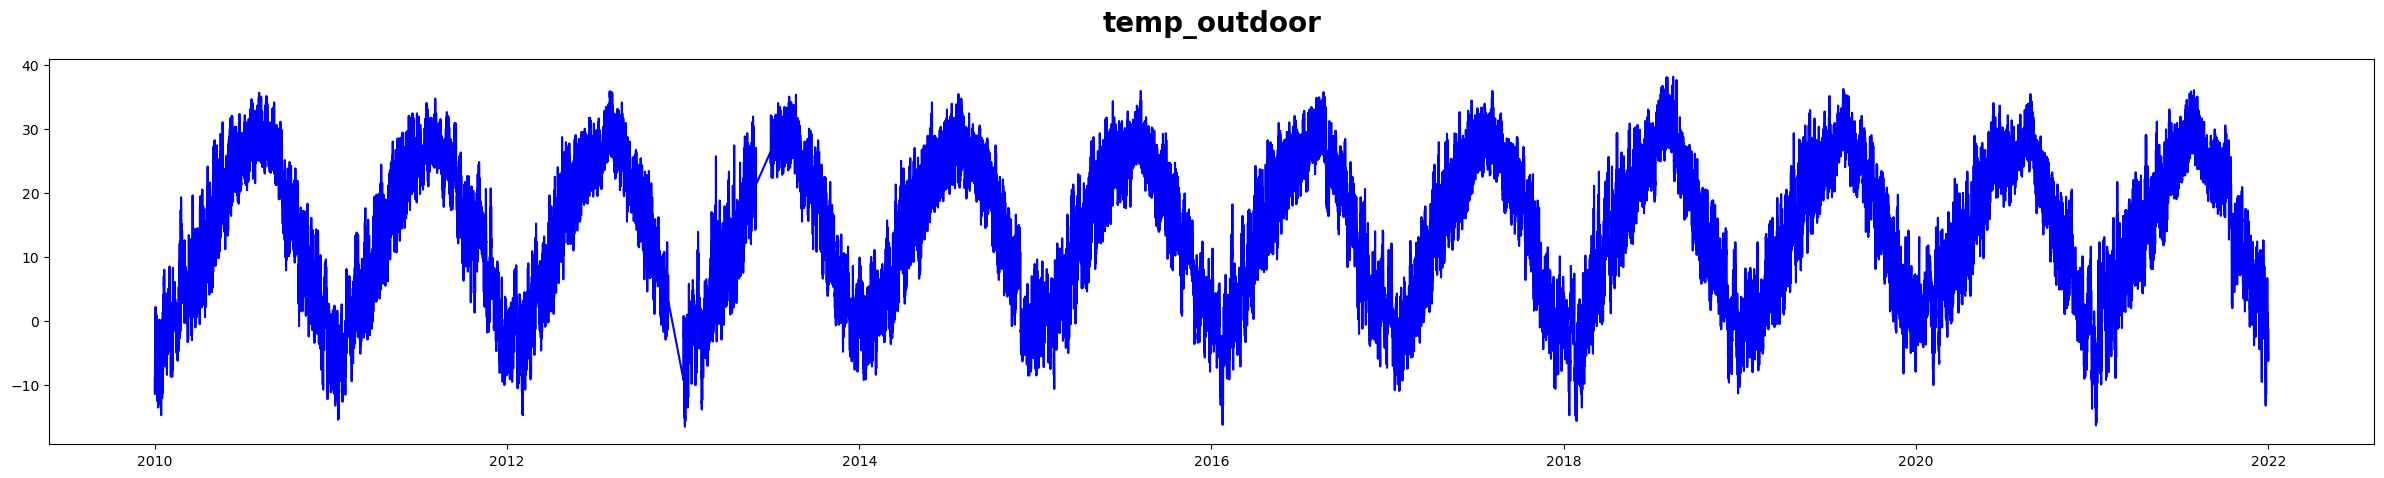

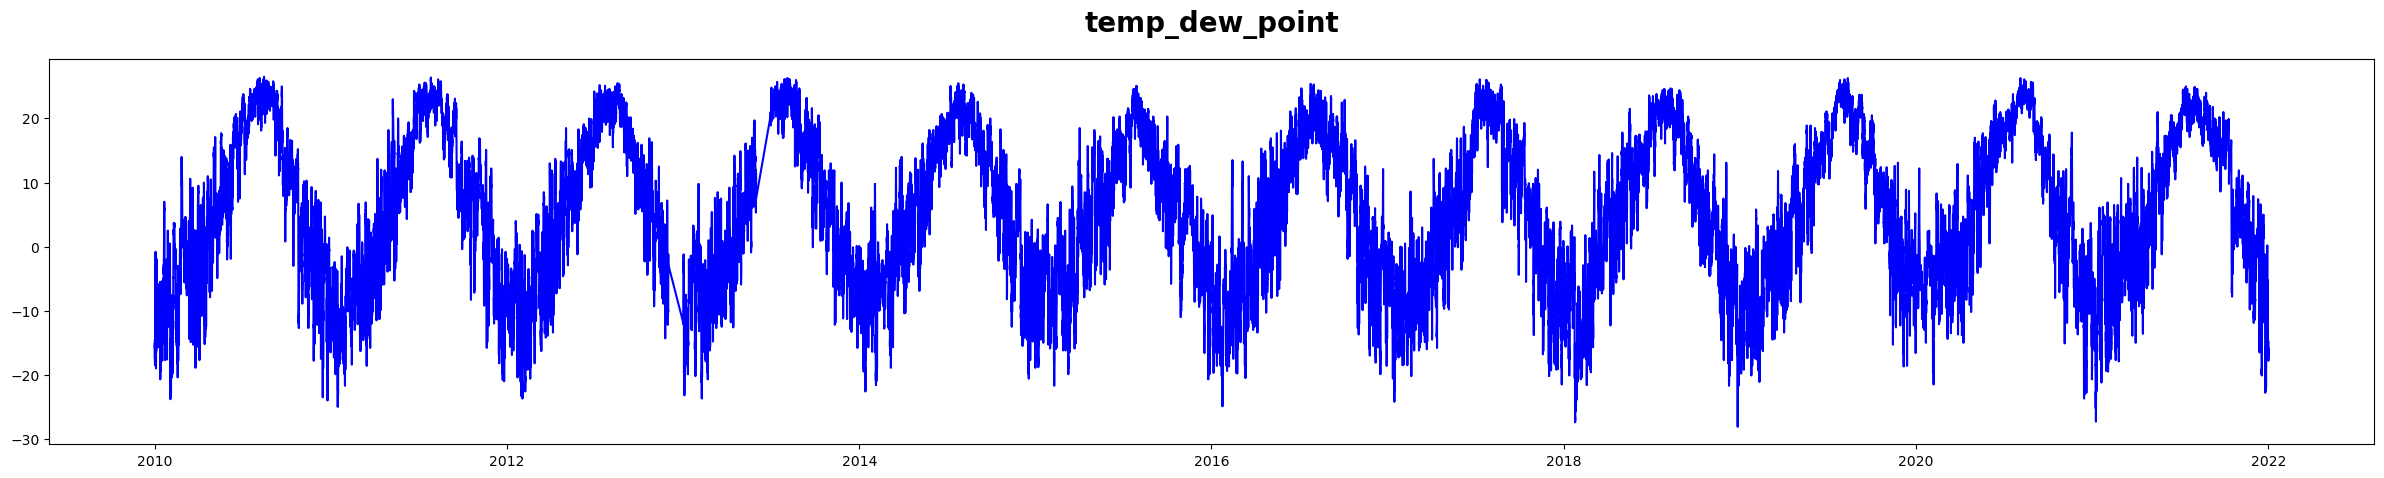

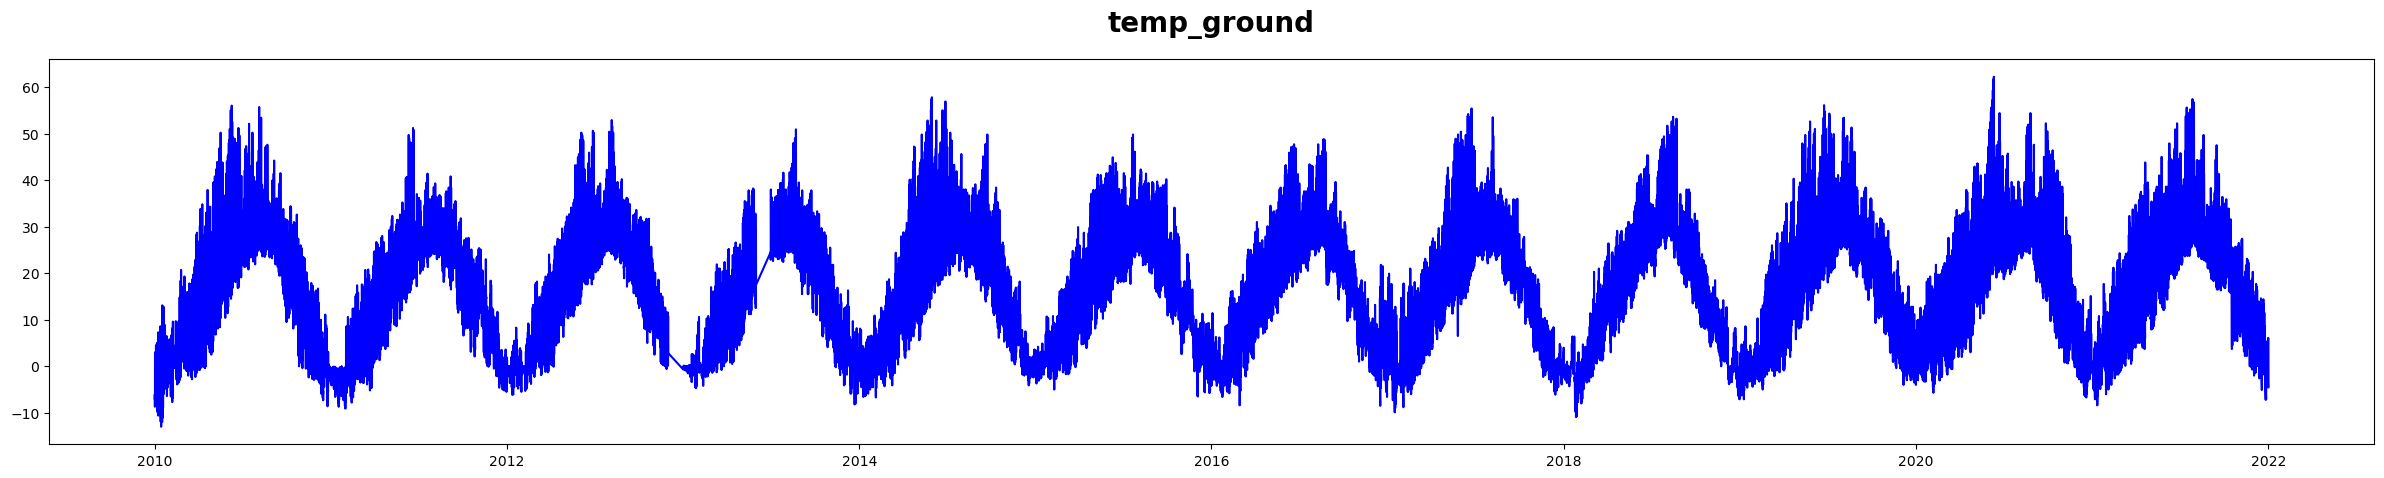

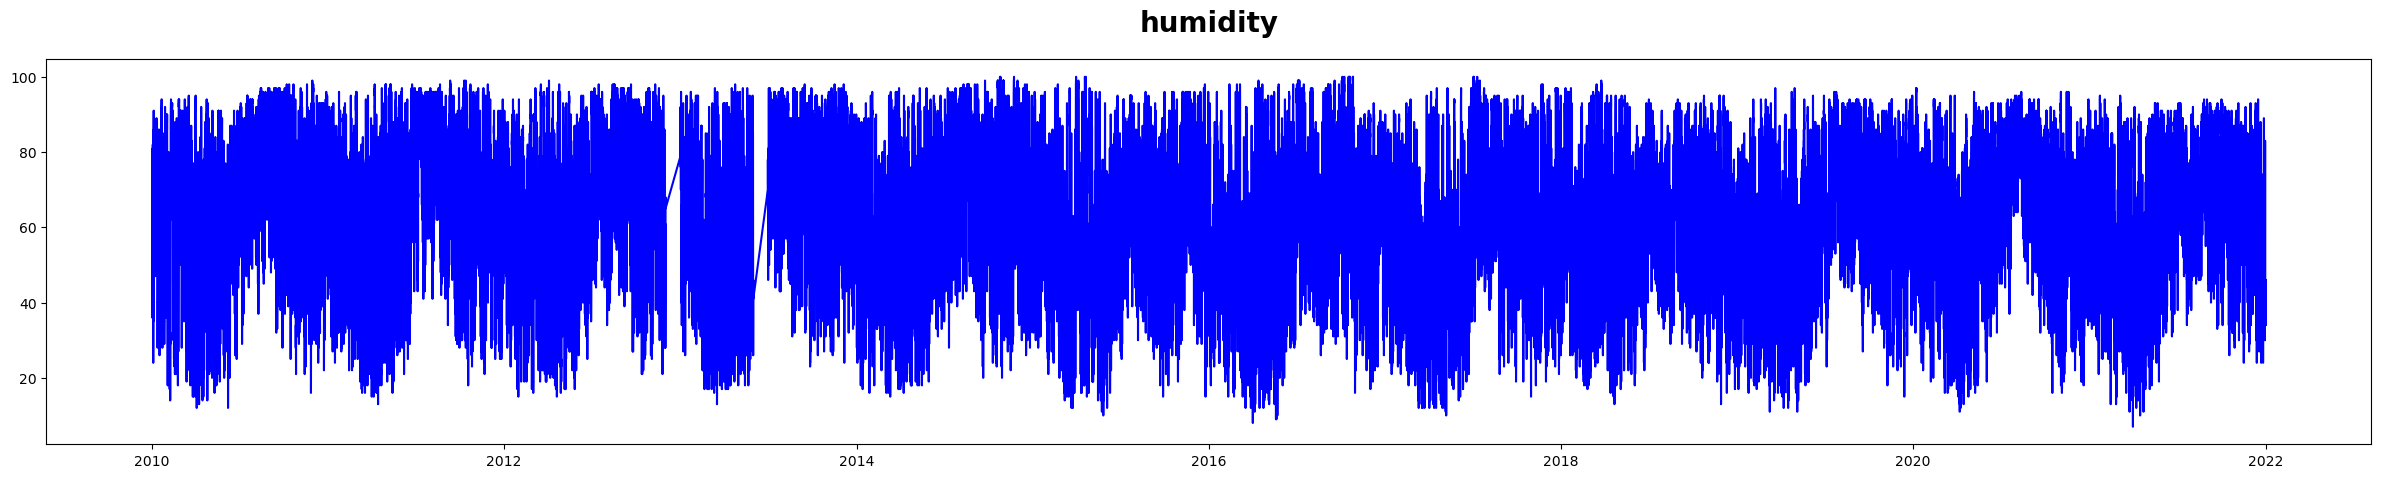

In [23]:
## 시각화 - 온습도 변수 비교
# fig, ax1 = plt.subplots(figsize=(30,5))
# ax1.plot(date, df_raw['CHEONGJU'], color='blue')
# plt.show()
visualization_df(df_raw, 'temp_outdoor', 'blue')
visualization_df(df_raw, 'temp_dew_point', 'blue')
visualization_df(df_raw, 'temp_ground', 'blue')
visualization_df(df_raw, 'humidity', 'blue')

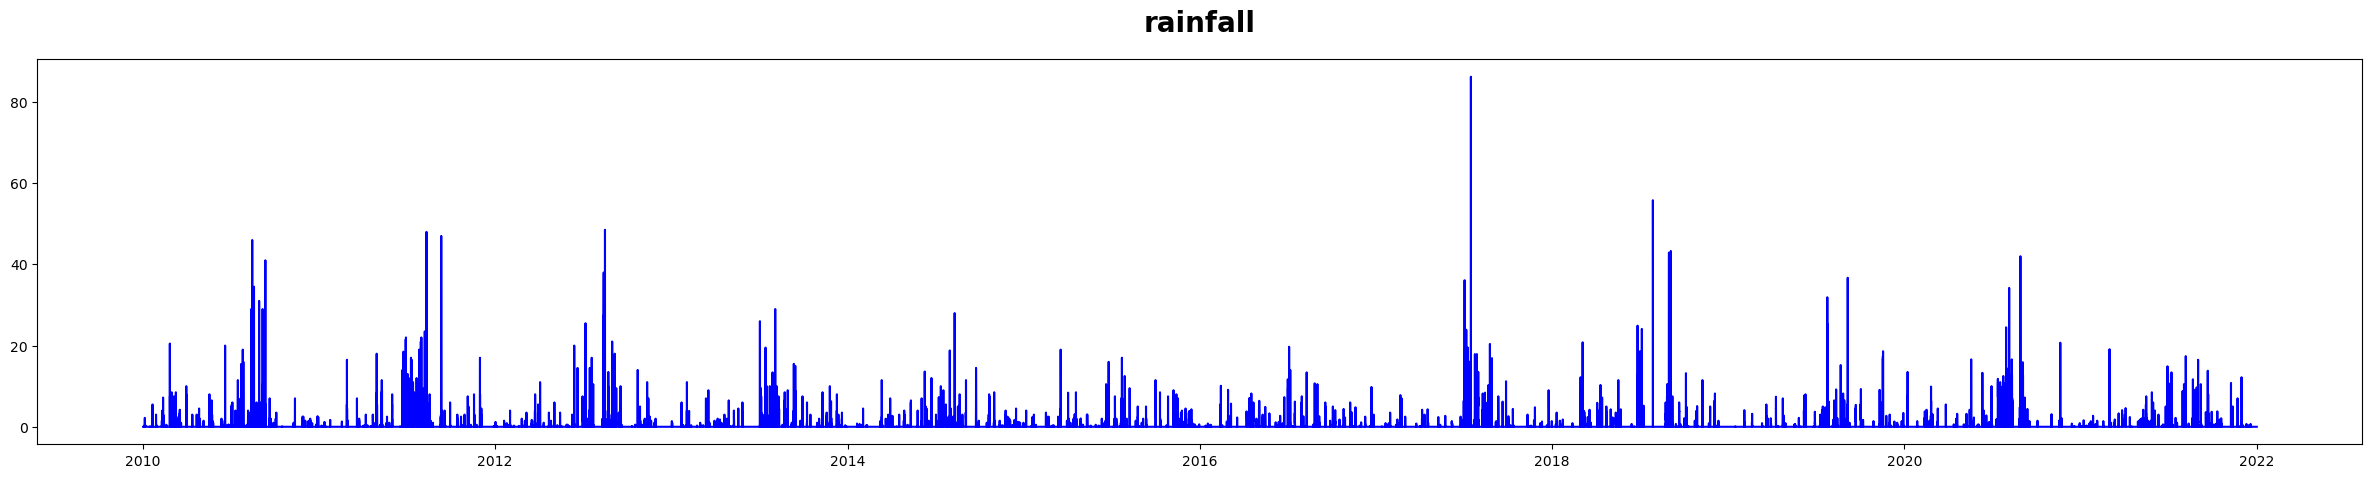

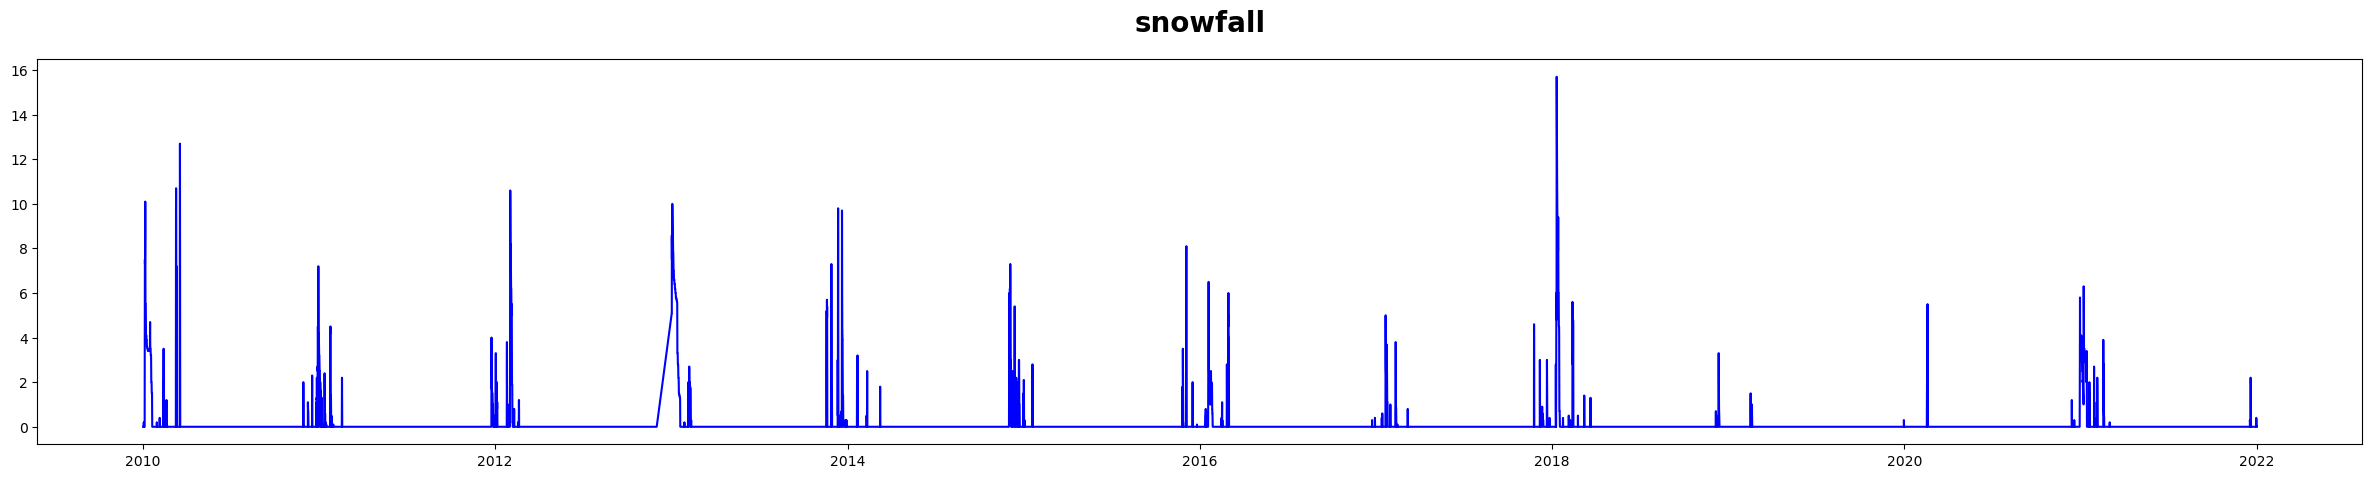

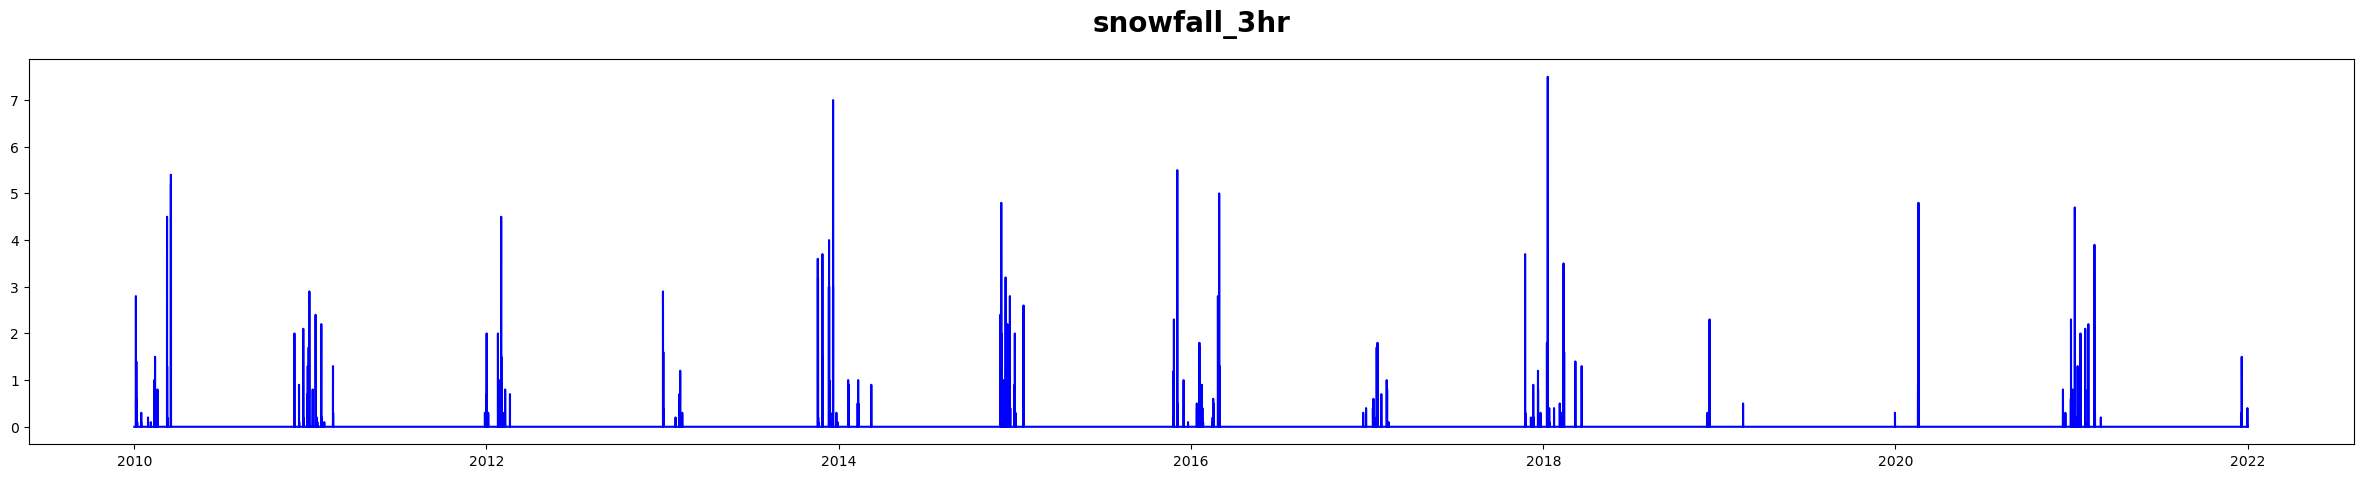

In [24]:
## 강우 변수 비교
visualization_df(df_raw, 'rainfall', 'blue')
visualization_df(df_raw, 'snowfall', 'blue')
visualization_df(df_raw, 'snowfall_3hr', 'blue')

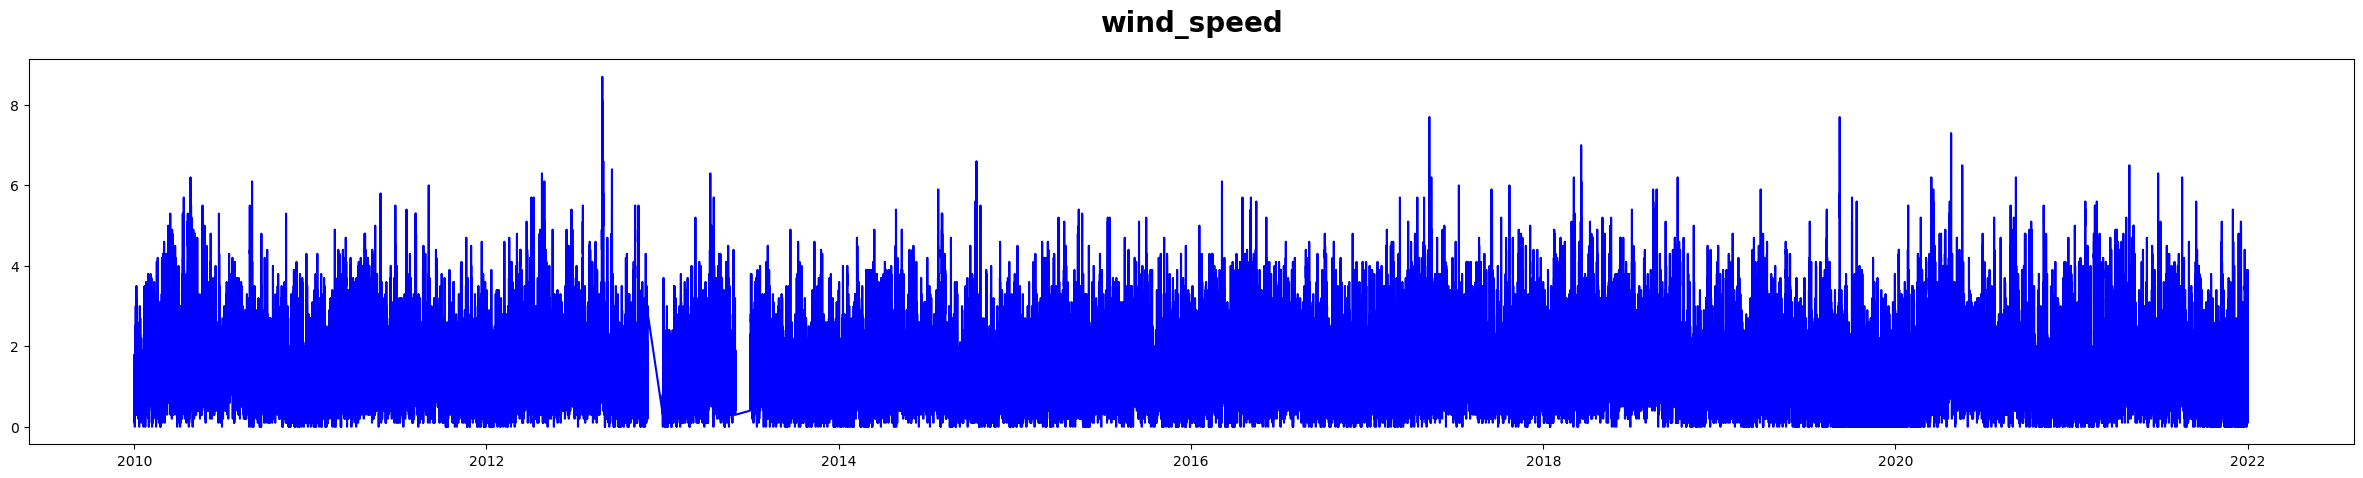

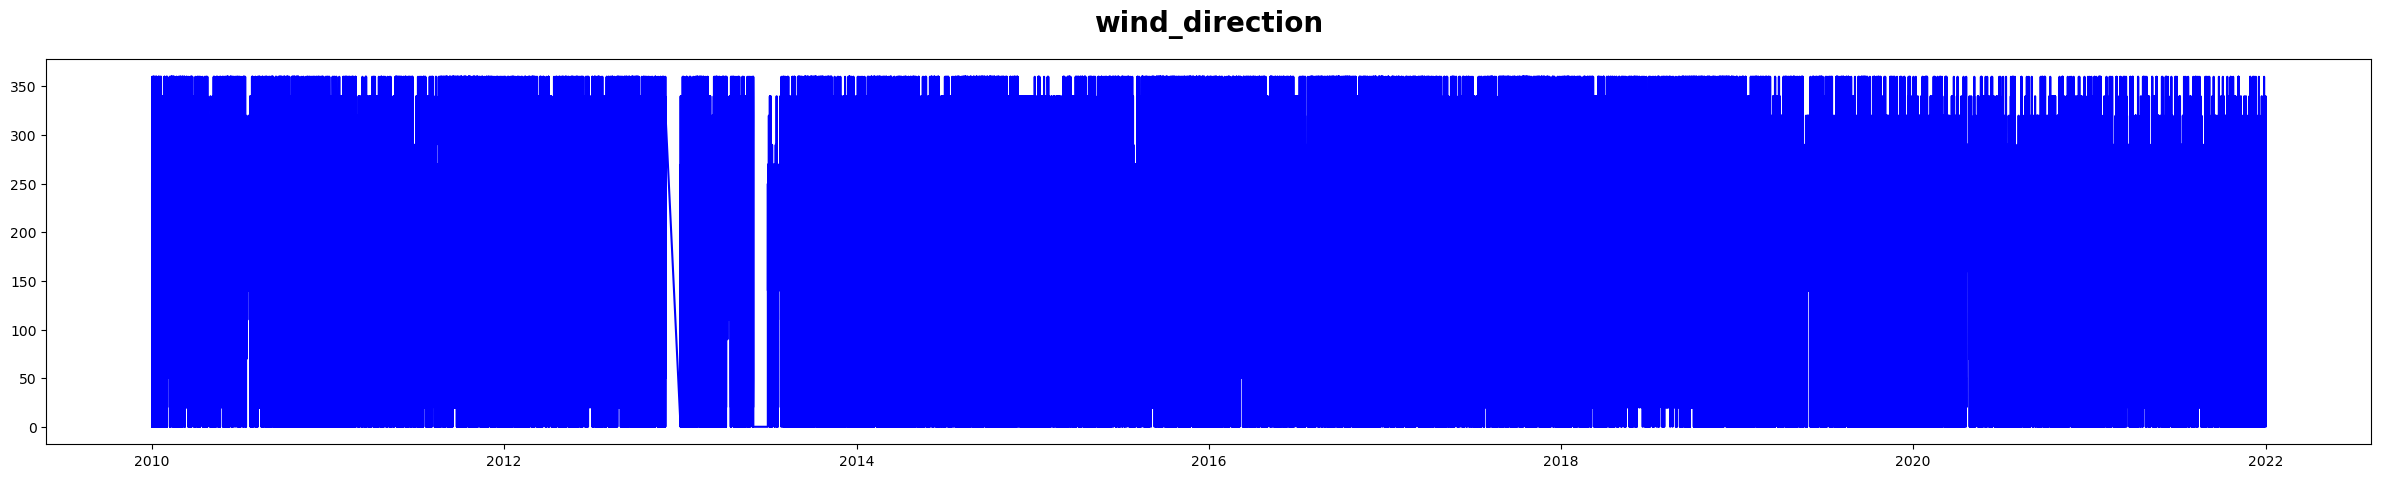

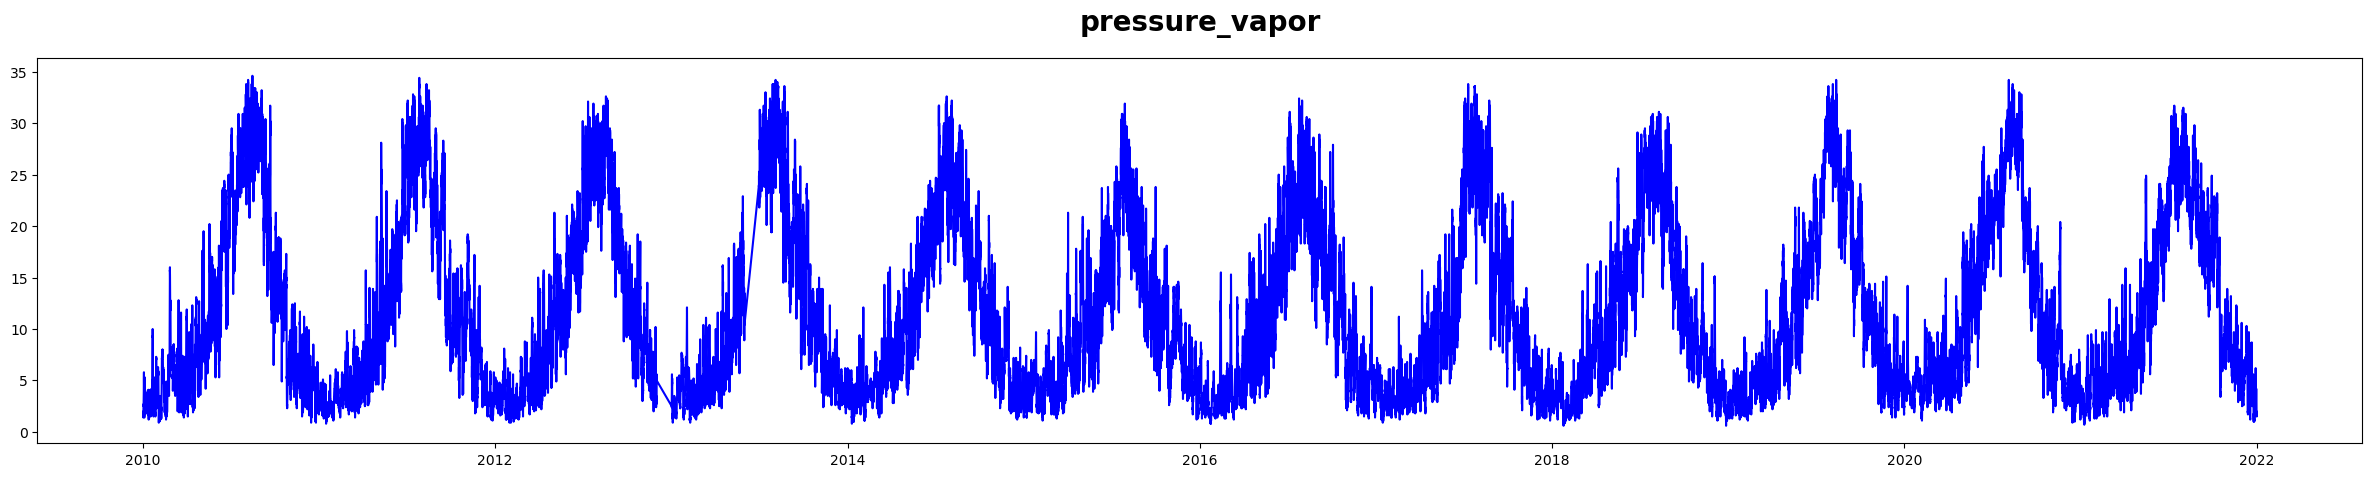

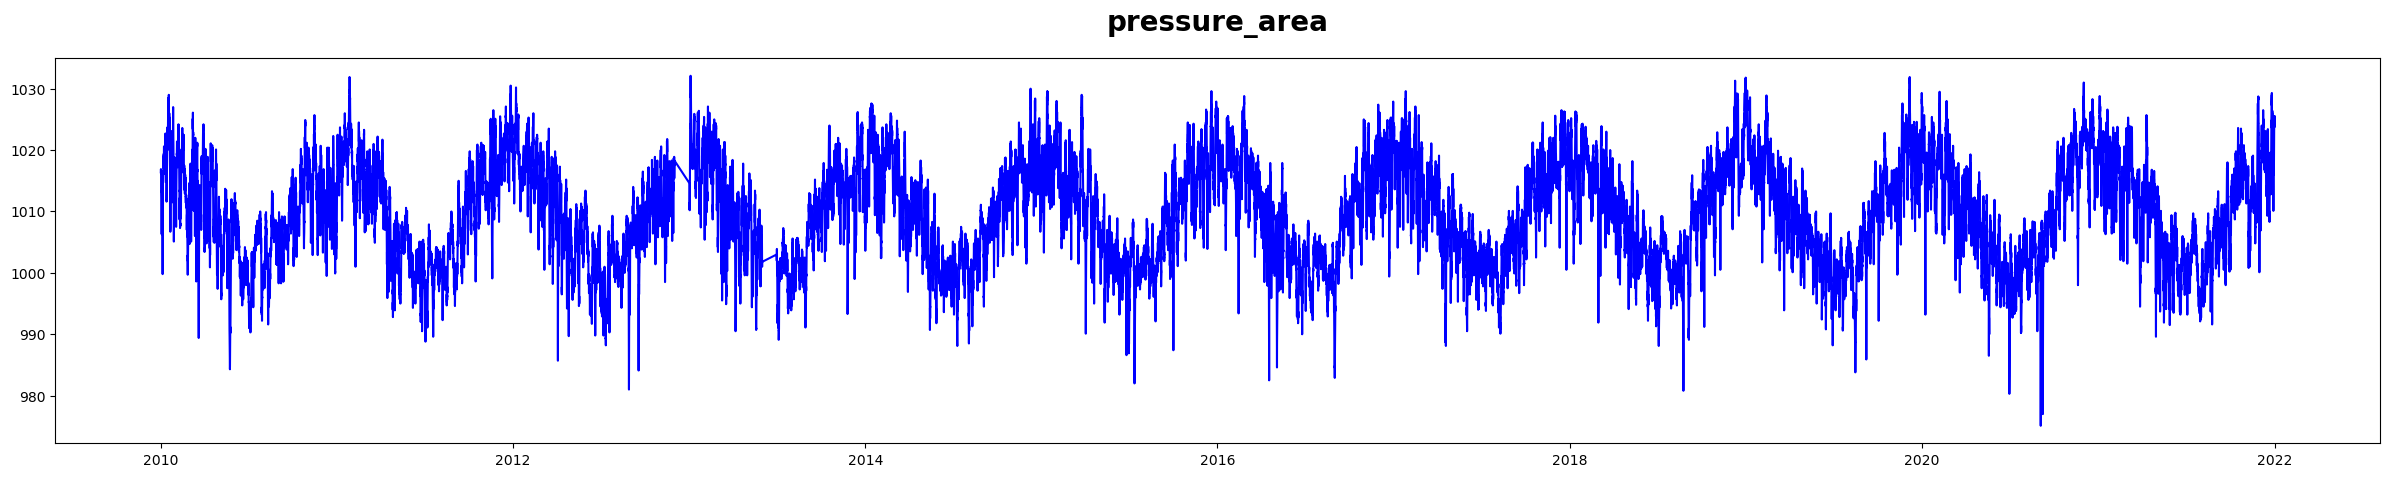

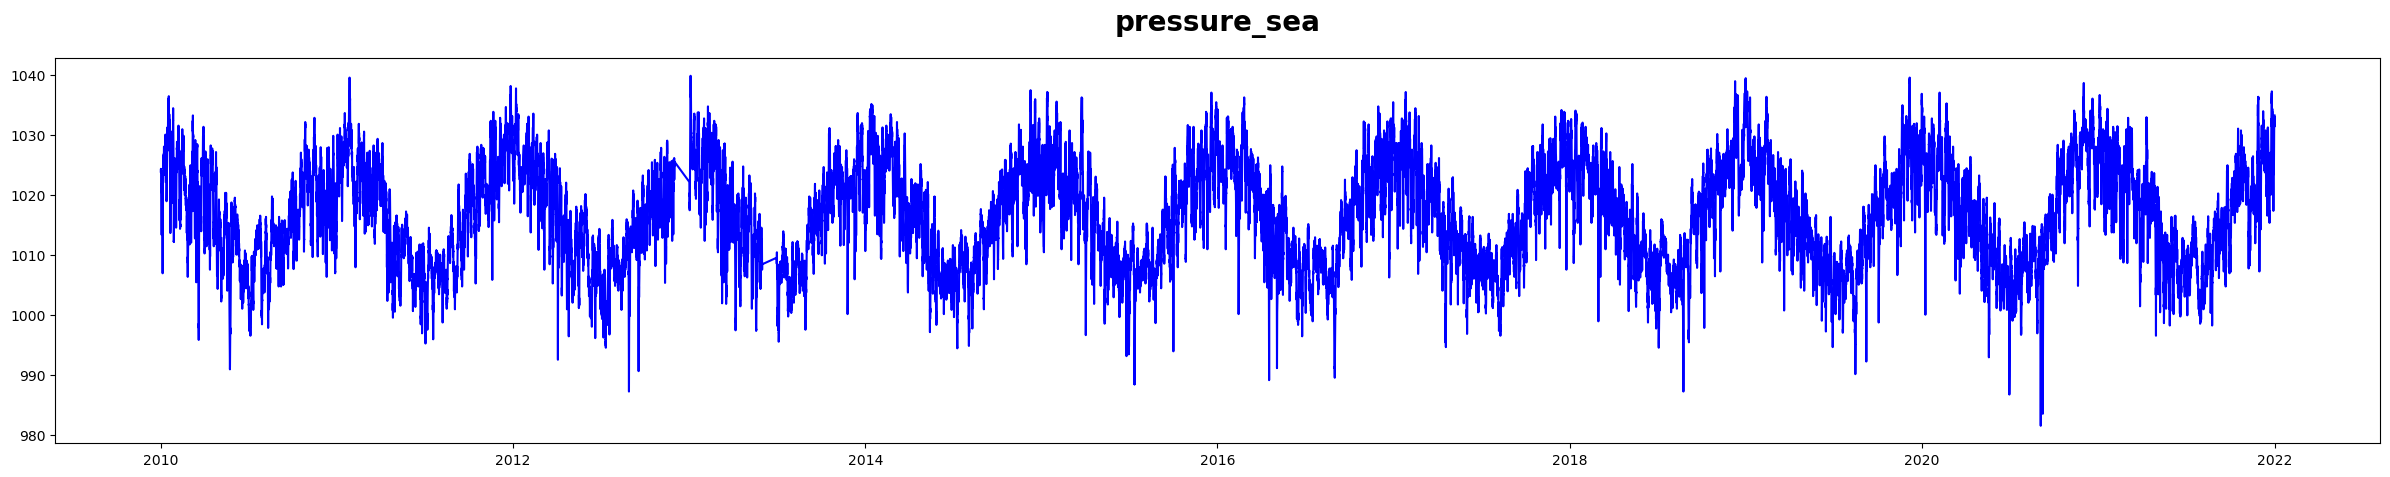

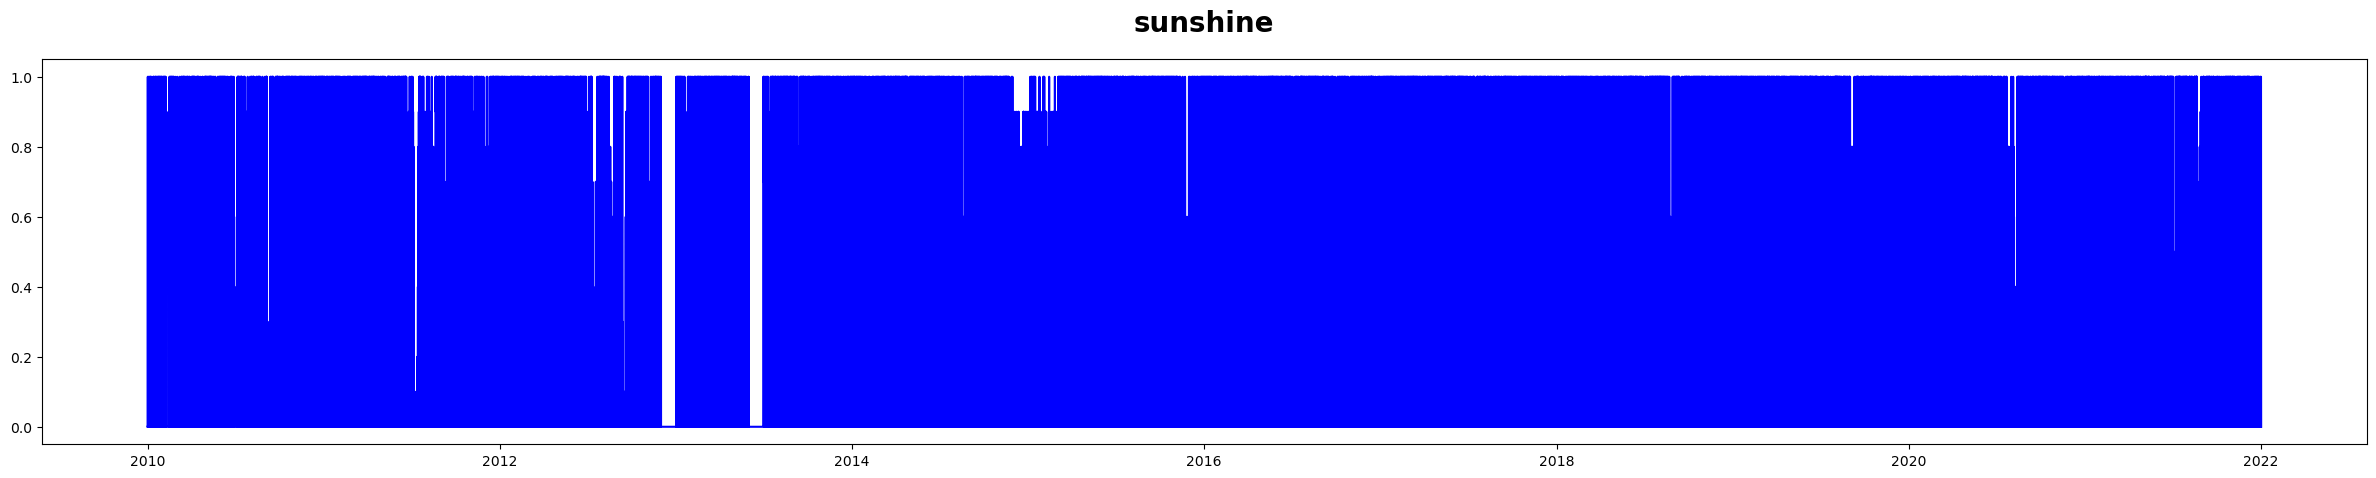

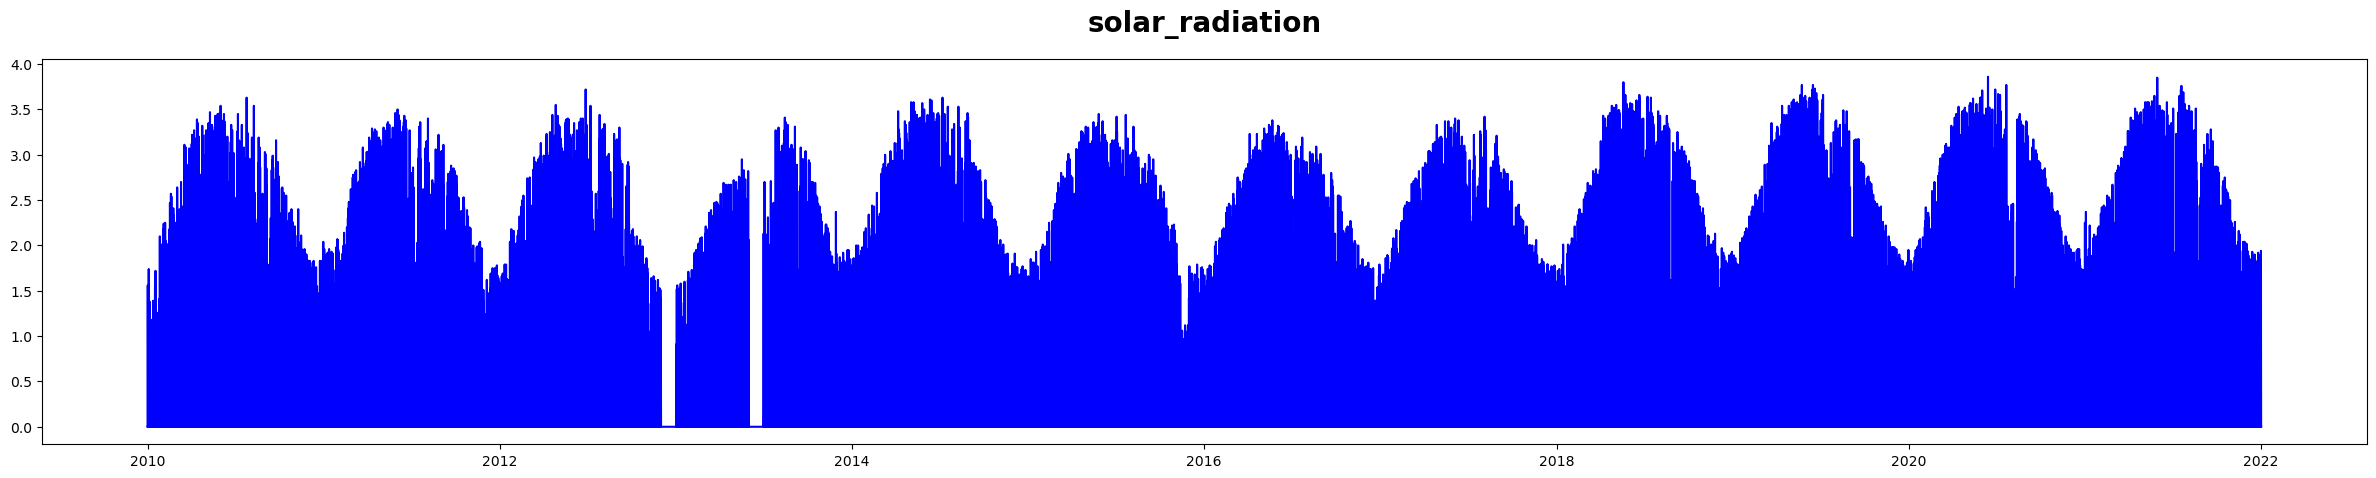

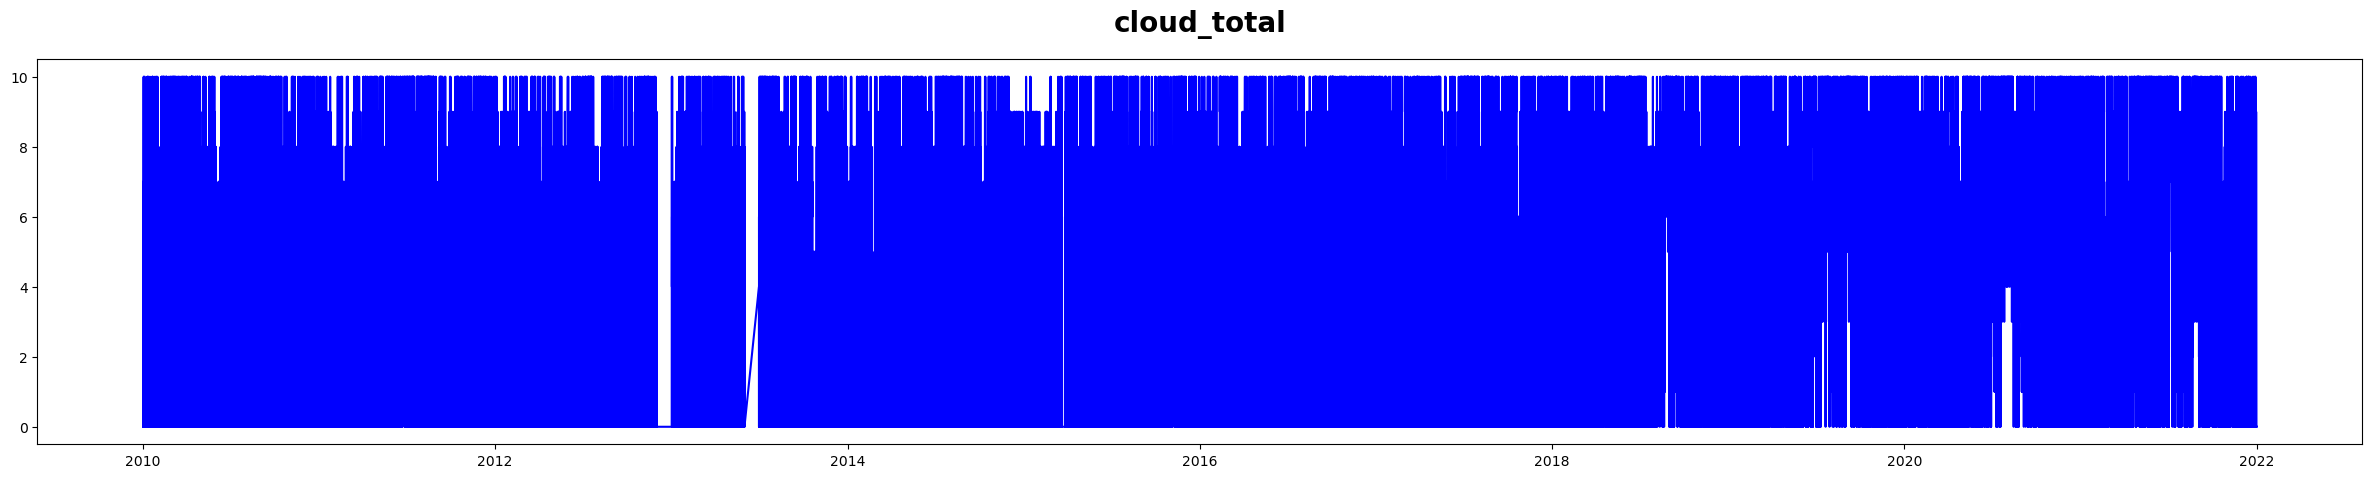

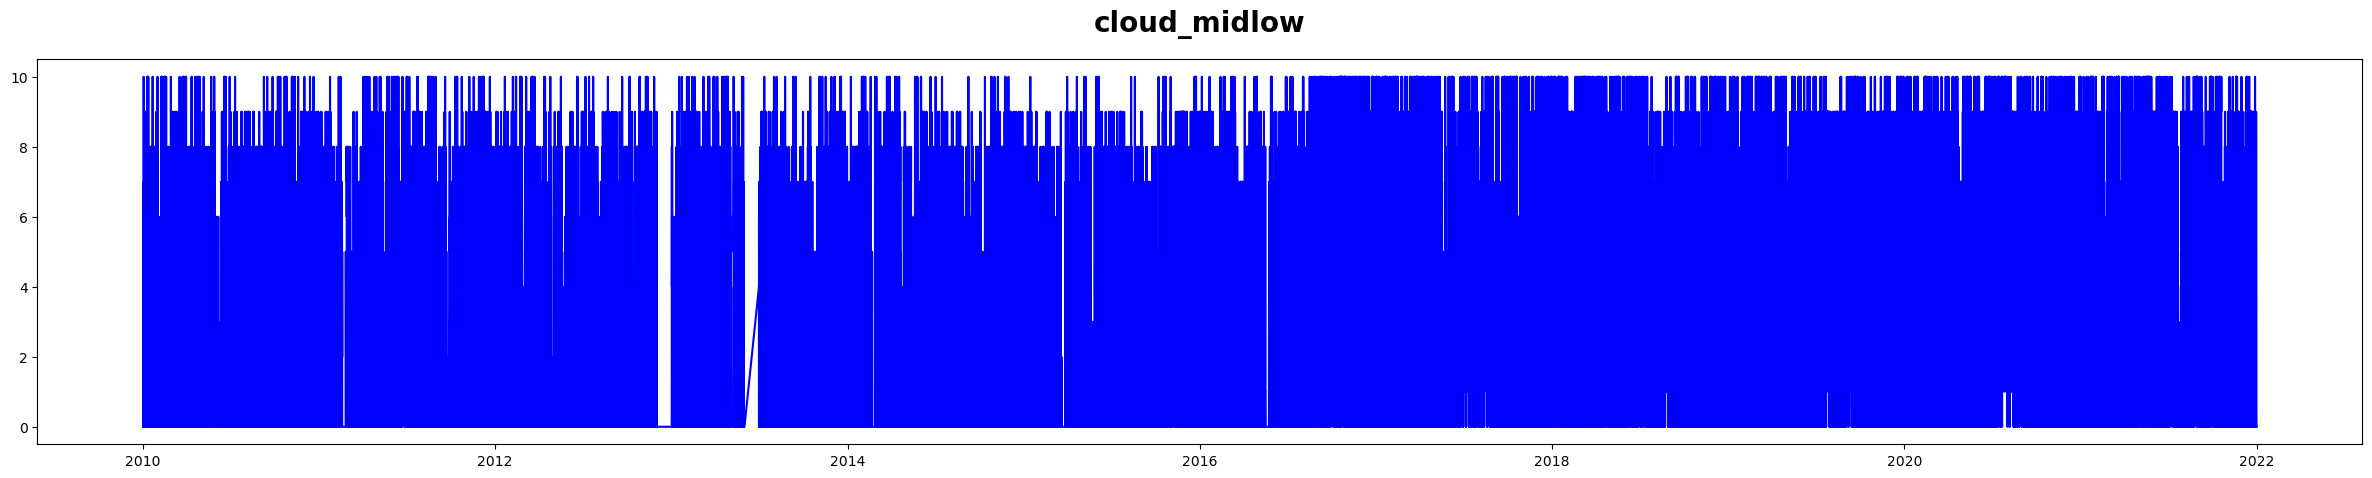

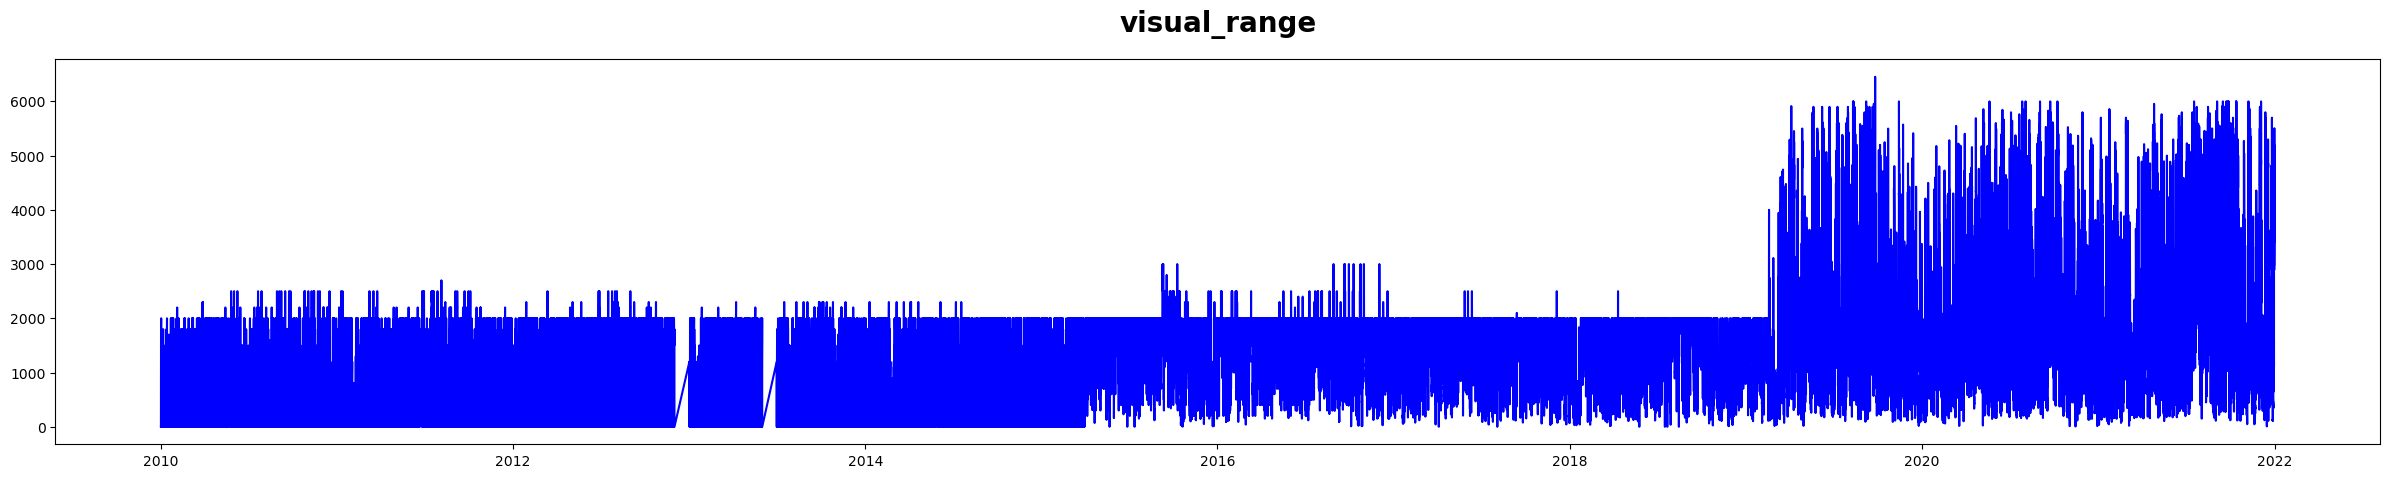

In [25]:
## 대기 변수 비교
visualization_df(df_raw, 'wind_speed', 'blue')
visualization_df(df_raw, 'wind_direction', 'blue')
visualization_df(df_raw, 'pressure_vapor', 'blue')
visualization_df(df_raw, 'pressure_area', 'blue')
visualization_df(df_raw, 'pressure_sea', 'blue')
visualization_df(df_raw, 'sunshine', 'blue')
visualization_df(df_raw, 'solar_radiation', 'blue')
visualization_df(df_raw, 'cloud_total', 'blue')
visualization_df(df_raw, 'cloud_midlow', 'blue')
visualization_df(df_raw, 'visual_range', 'blue')

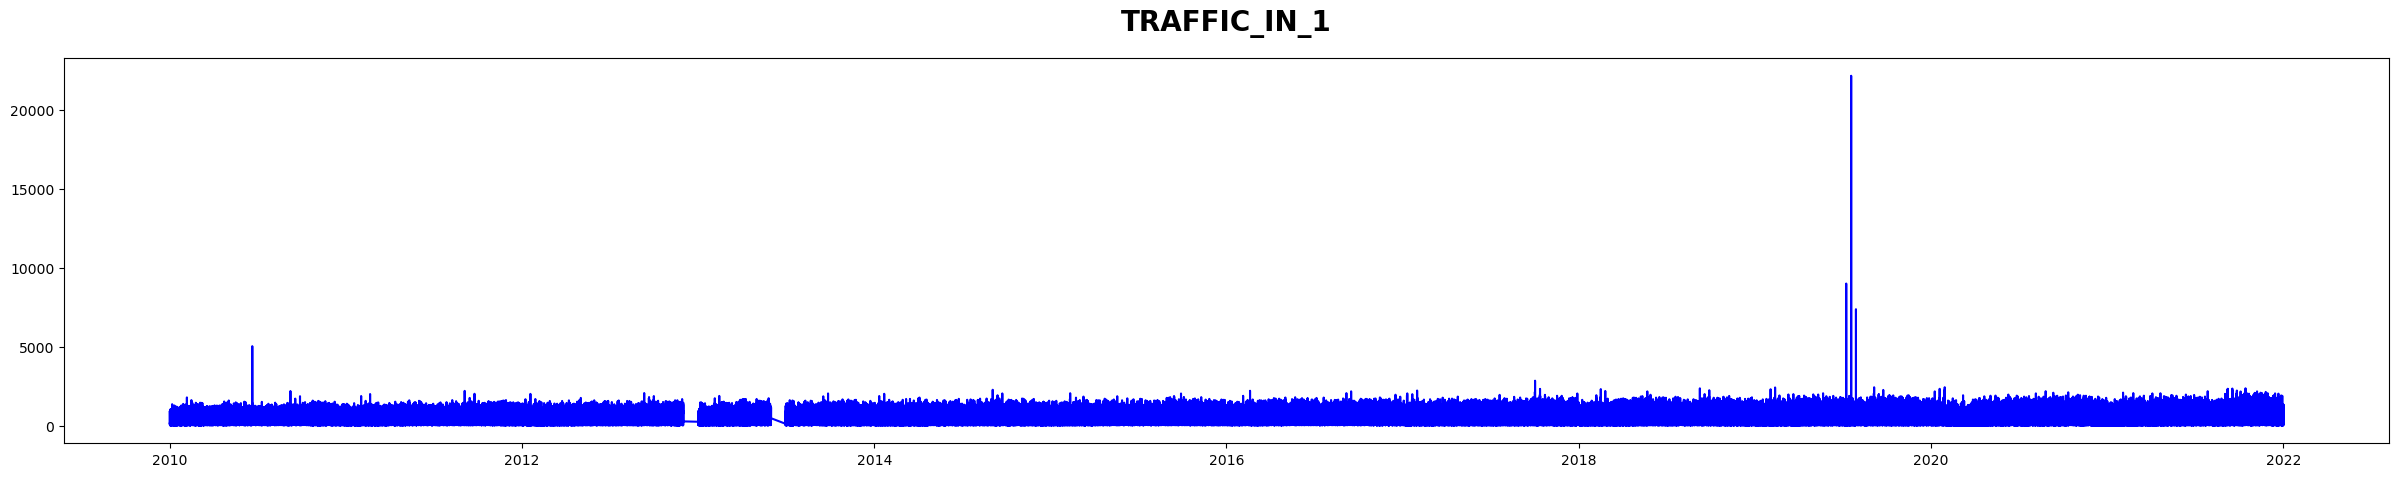

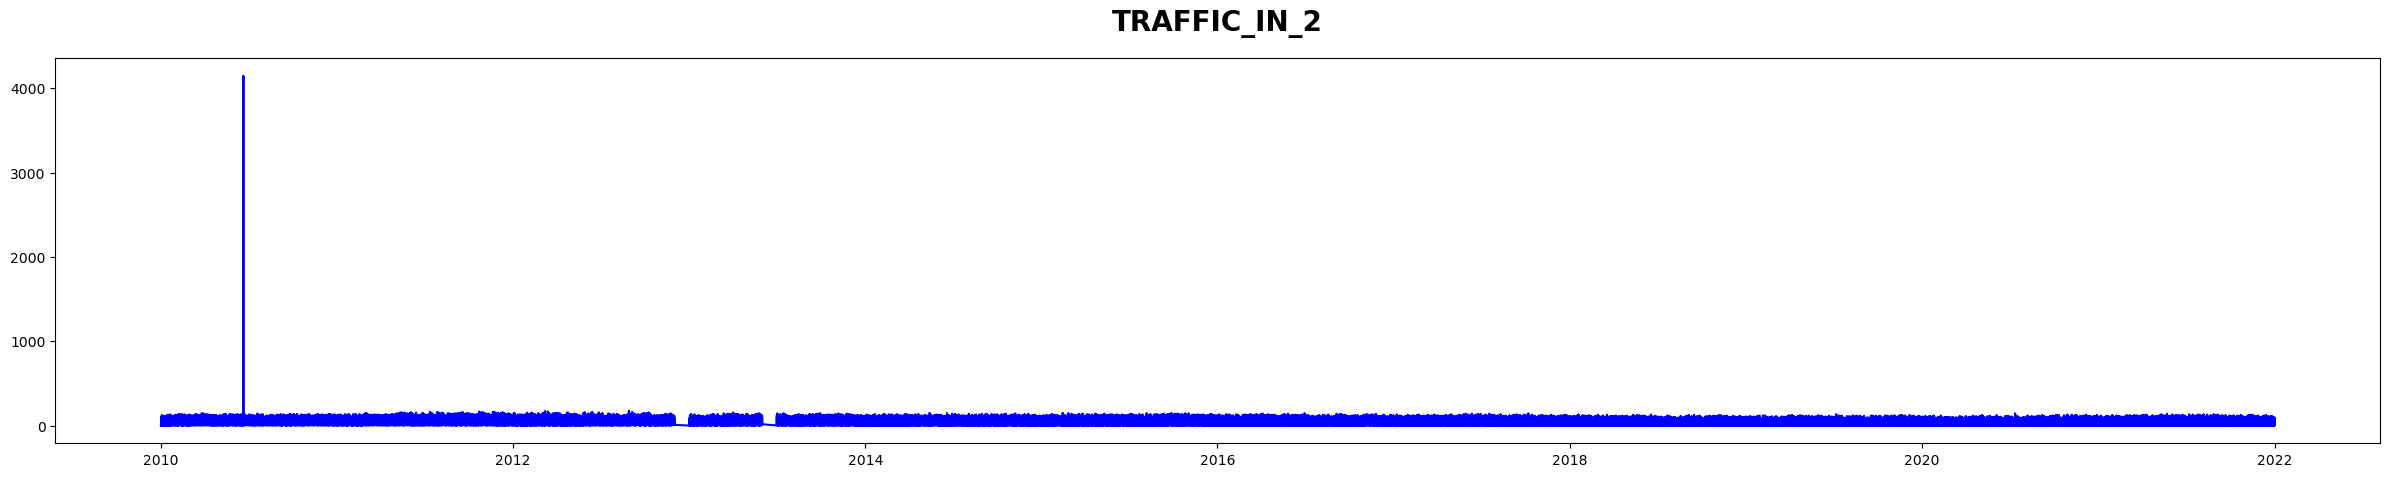

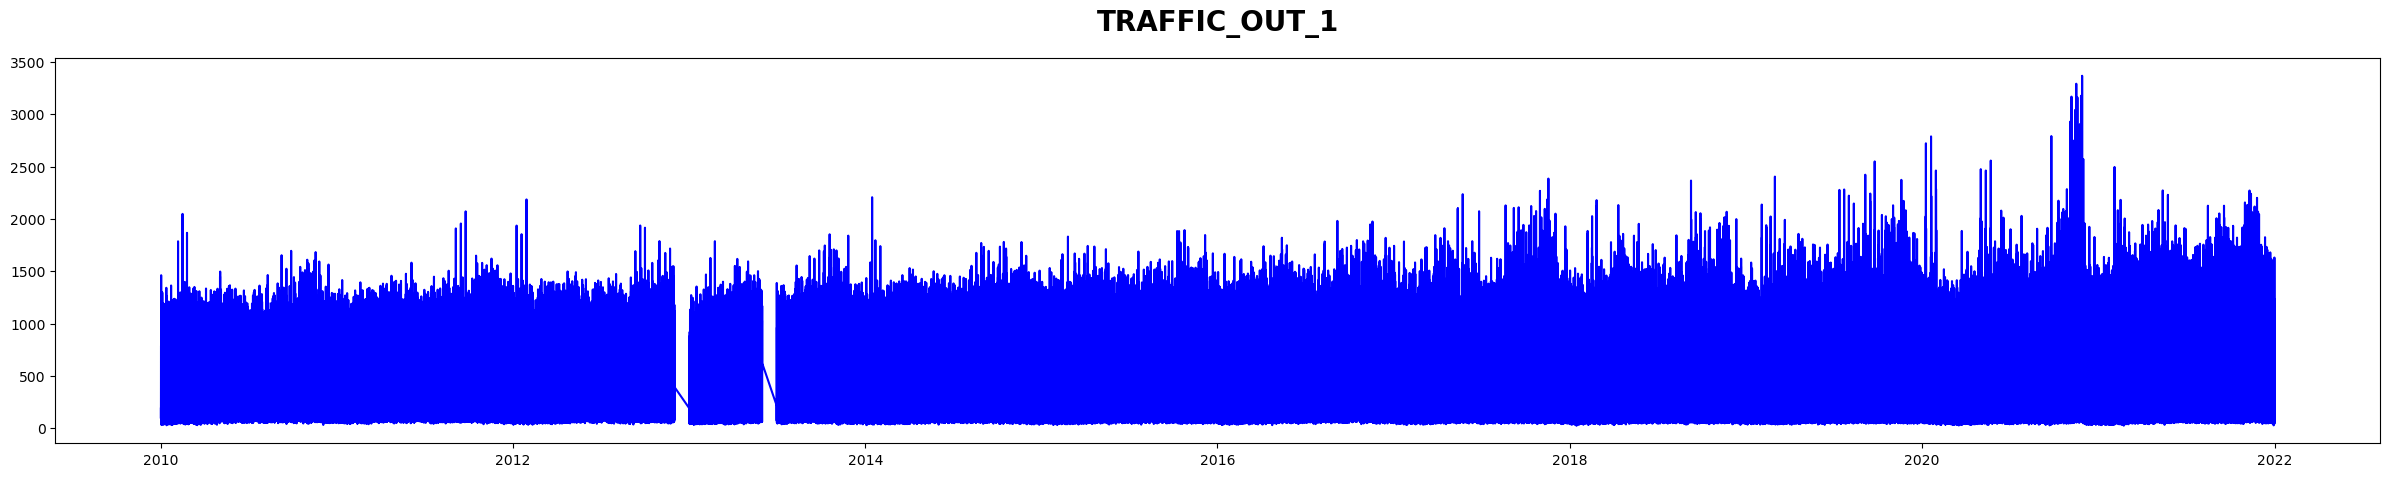

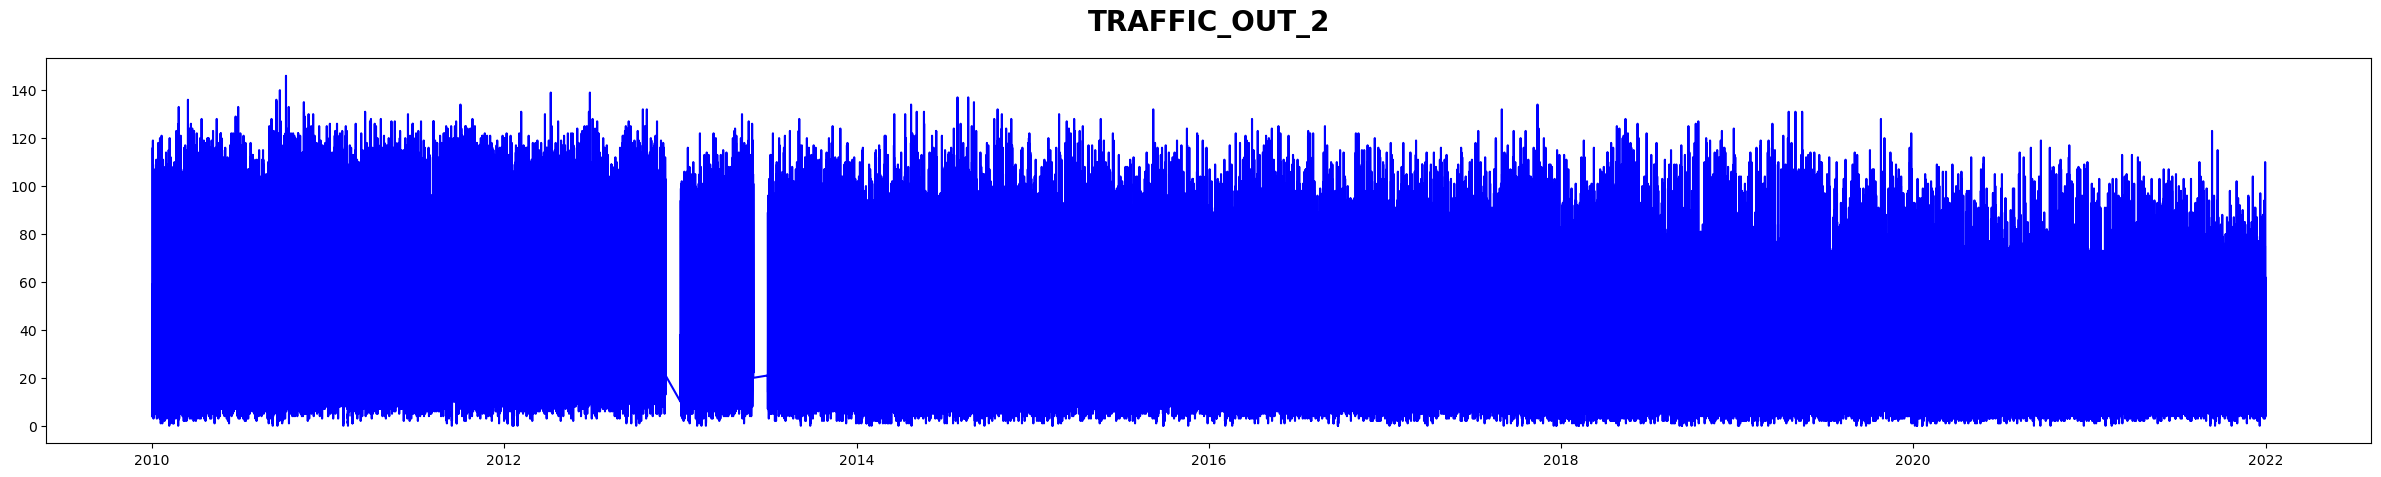

In [26]:
## 교통변수 비교
visualization_df(df_raw, 'TRAFFIC_IN_1', 'blue')
visualization_df(df_raw, 'TRAFFIC_IN_2', 'blue')
visualization_df(df_raw, 'TRAFFIC_OUT_1', 'blue')
visualization_df(df_raw, 'TRAFFIC_OUT_2', 'blue')

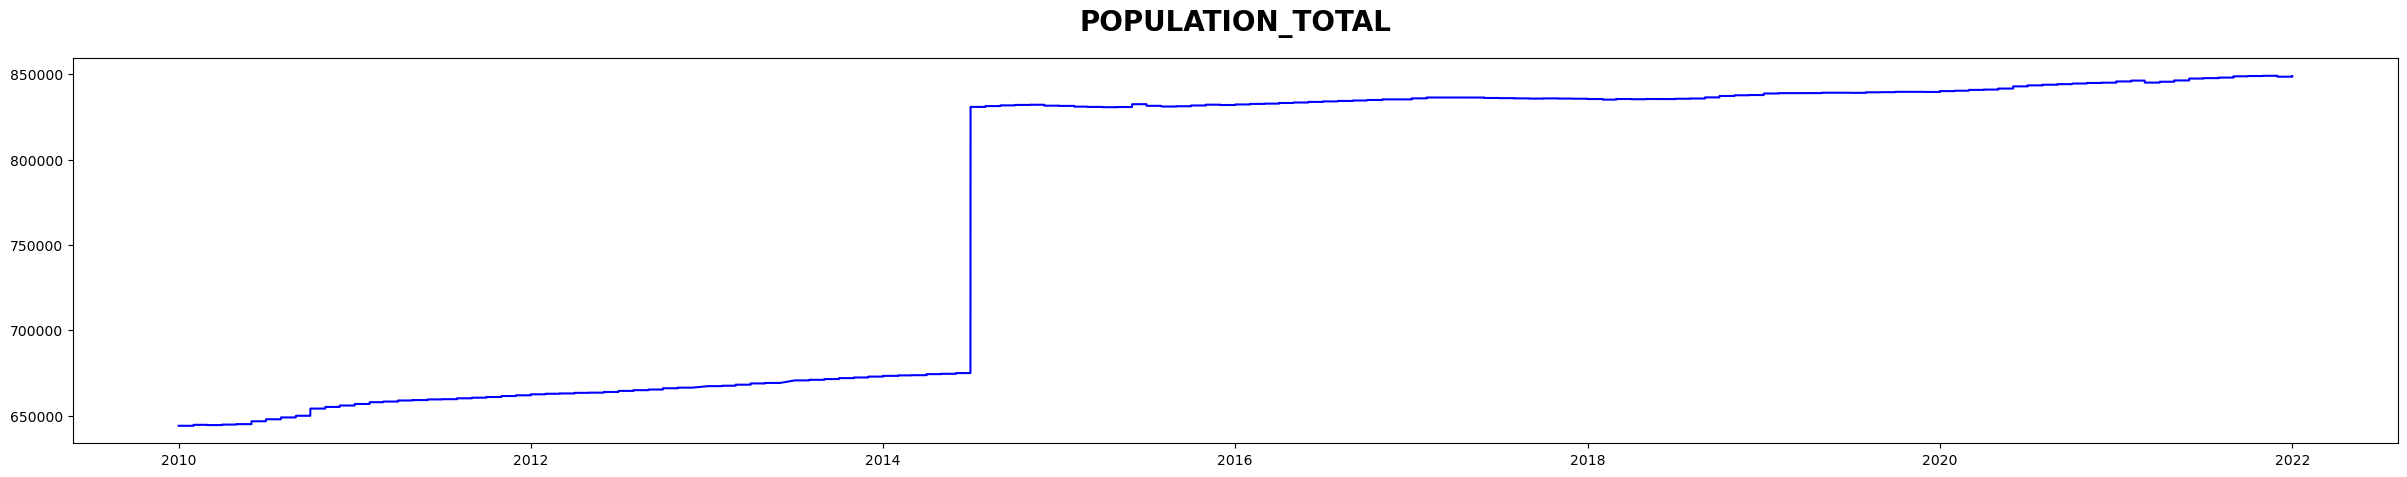

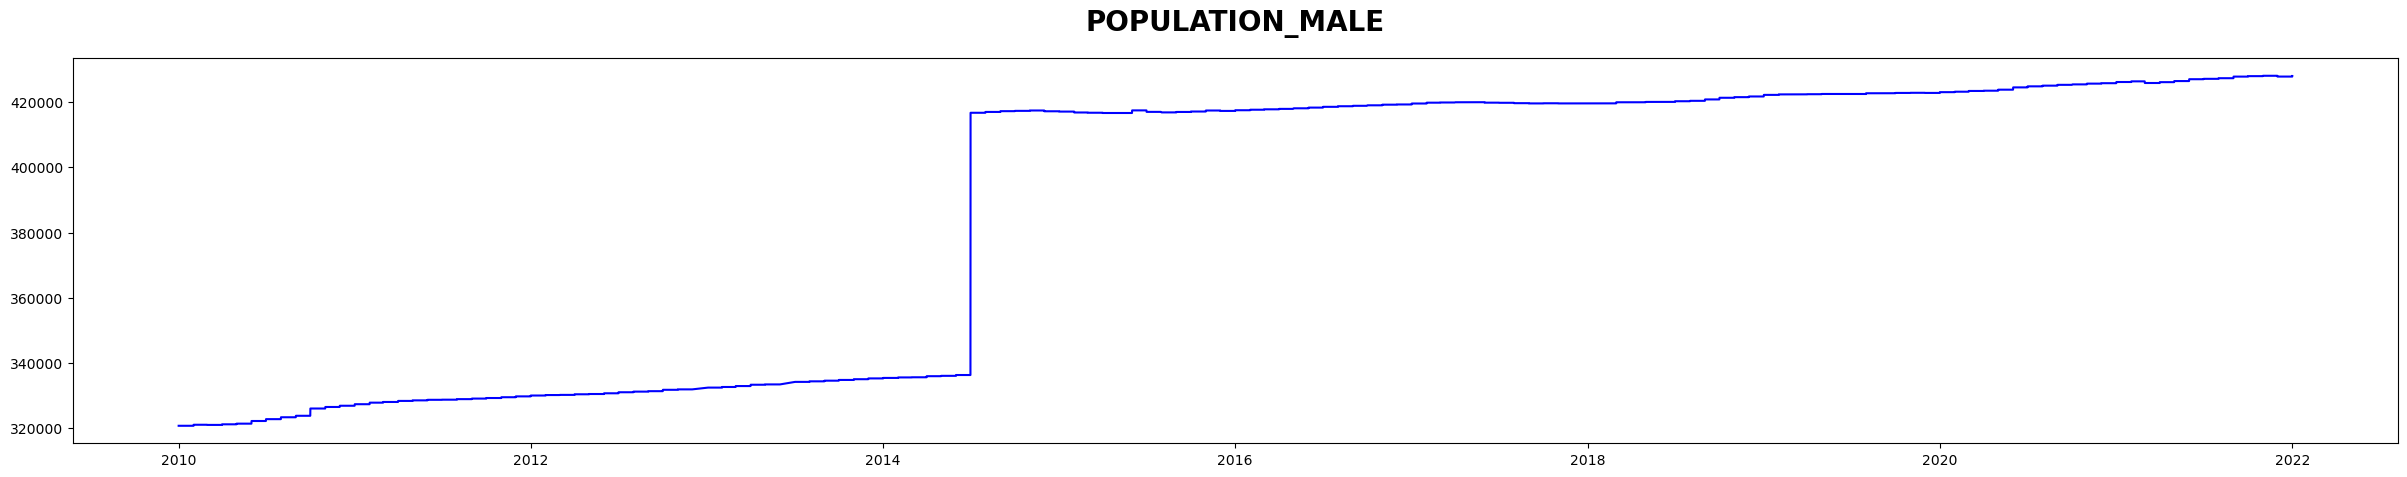

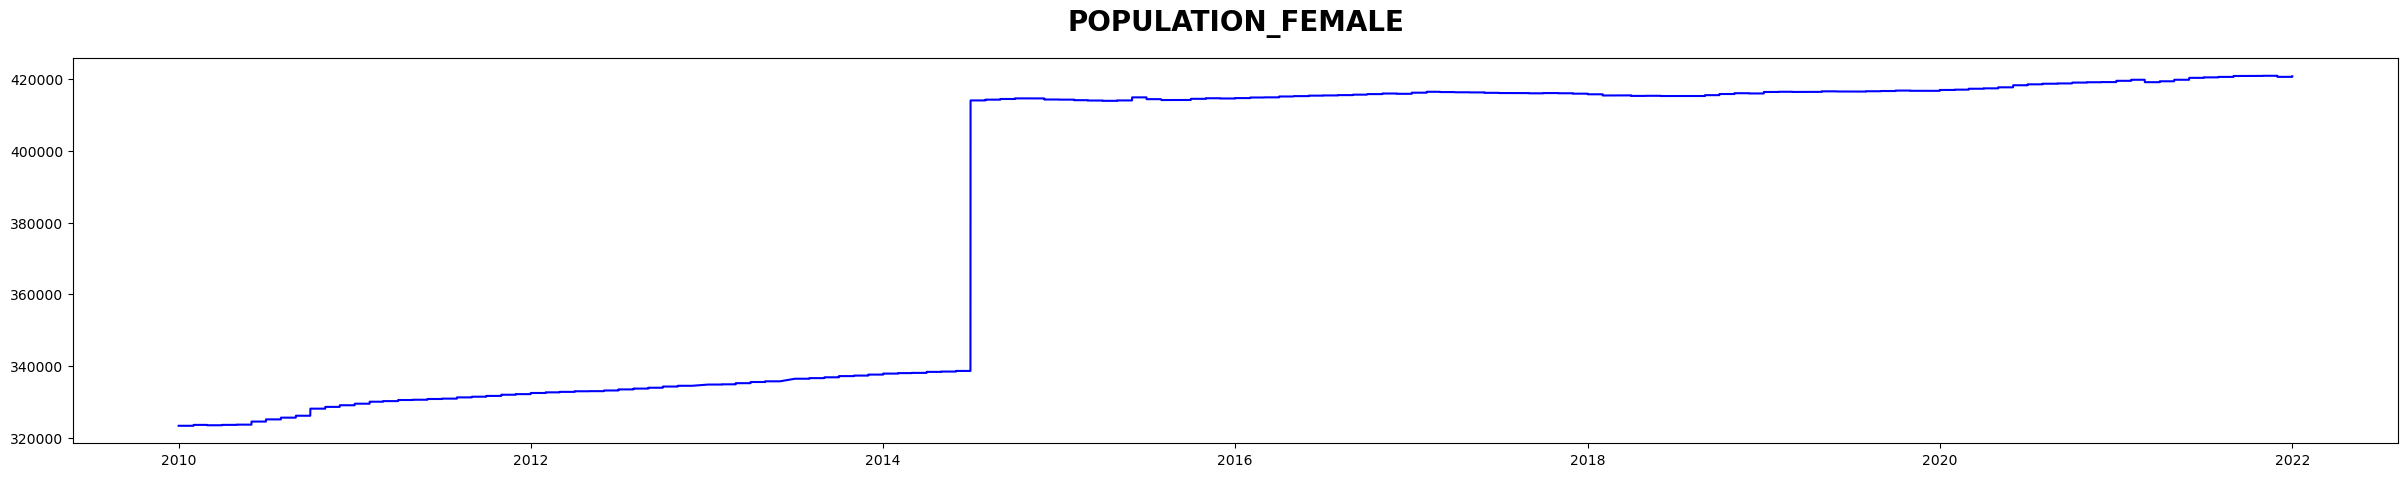

In [27]:
## 인구 변수 비교
visualization_df(df_raw, 'POPULATION_TOTAL', 'blue')
visualization_df(df_raw, 'POPULATION_MALE', 'blue')
visualization_df(df_raw, 'POPULATION_FEMALE', 'blue')

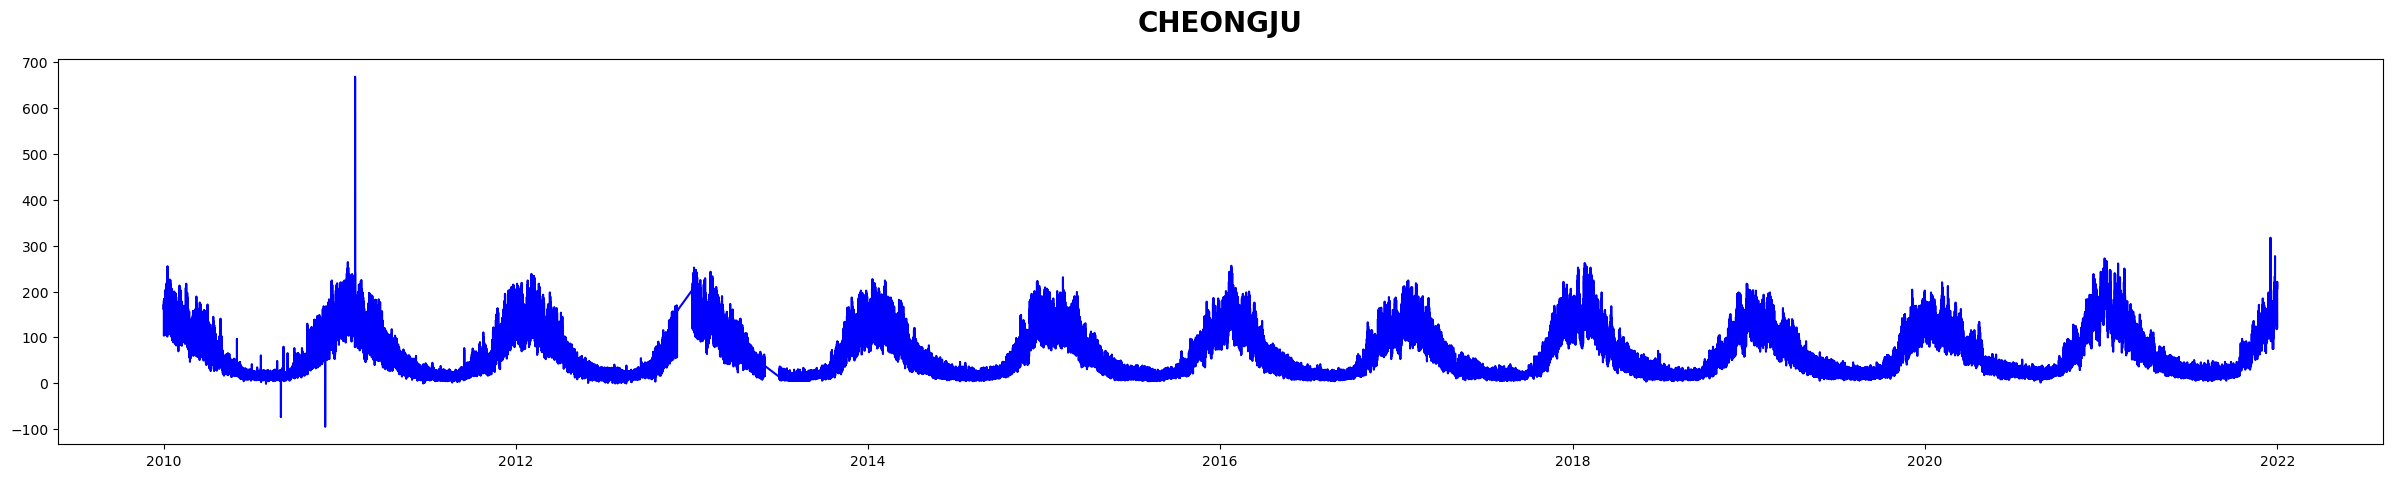

In [28]:
## 타겟 시각화
visualization_df(df_raw, 'CHEONGJU', 'blue')

In [29]:
df_raw.columns

Index(['METER_DATE', 'day_of_the_week', 'YEAR', 'MONTH', 'DAY', 'HOUR',
       'MINUTE', 'code_day_of_the_week', 'dist_from_holiday', 'rest_YN',
       'temp_outdoor', 'temp_dew_point', 'temp_ground', 'humidity', 'rainfall',
       'snowfall', 'snowfall_3hr', 'wind_speed', 'wind_direction',
       'pressure_vapor', 'pressure_area', 'pressure_sea', 'sunshine',
       'solar_radiation', 'cloud_total', 'cloud_midlow', 'visual_range',
       'CHEONGJU', 'TRAFFIC_IN_1', 'TRAFFIC_IN_2', 'TRAFFIC_OUT_1',
       'TRAFFIC_OUT_2', 'POPULATION_TOTAL', 'POPULATION_MALE',
       'POPULATION_FEMALE'],
      dtype='object')

### 01-04-02. Remove Outlier (IQR)

In [30]:
## 이상치 기준 생성
## Q3 : 100개의 데이터로 가정 시, 25번째로 높은 값에 해당
## Q1 : 100개의 데이터로 가정 시, 75번째로 높은 값에 해당
## IQR : Q3 - Q1의 차이를 의미
## 이상치 : Q3 + 1.5 * IQR보다 높거나 Q1 - 1.5 * IQR보다 낮은 값을 의미
col_tar = 'CHEONGJU'
find_outlier_Usages(df_raw, col_tar)
del_outlier_Usages(df_raw, col_tar)

col_tar = 'TRAFFIC_IN_1'
find_outlier_Usages(df_raw, col_tar)
del_outlier_Usages(df_raw, col_tar)

col_tar = 'TRAFFIC_IN_2'
find_outlier_Usages(df_raw, col_tar)
del_outlier_Usages(df_raw, col_tar)

===============  IQR Range =============== 
335.5
148.0
125.0
44.0
23.0
-164.5
===============  IQR Range =============== 
cnt_outlier = 7
===============  IQR Range =============== 
335.5
148.0
125.0
44.0
23.0
-164.5
===============  IQR Range =============== 
cnt_outlier = 7
7
===============  IQR Range =============== 
2765.0
1232.0
1022.0
727.0
210.0
-1323.0
===============  IQR Range =============== 
cnt_outlier = 6
===============  IQR Range =============== 
2765.0
1232.0
1022.0
727.0
210.0
-1323.0
===============  IQR Range =============== 
cnt_outlier = 6
6
===============  IQR Range =============== 
205.5
90.0
77.0
30.0
13.0
-102.5
===============  IQR Range =============== 
cnt_outlier = 1
===============  IQR Range =============== 
205.5
90.0
77.0
30.0
13.0
-102.5
===============  IQR Range =============== 
cnt_outlier = 1
1


METER_DATE day_of_the_week  YEAR  MONTH  DAY  HOUR  MINUTE  \
0       2010-01-01 01:00:00          Friday  2010      1    1     1       0   
1       2010-01-01 02:00:00          Friday  2010      1    1     2       0   
2       2010-01-01 03:00:00          Friday  2010      1    1     3       0   
3       2010-01-01 04:00:00          Friday  2010      1    1     4       0   
4       2010-01-01 05:00:00          Friday  2010      1    1     5       0   
...                     ...             ...   ...    ...  ...   ...     ...   
109571  2021-12-31 20:00:00          Friday  2021     12   31    20       0   
109572  2021-12-31 21:00:00          Friday  2021     12   31    21       0   
109573  2021-12-31 22:00:00          Friday  2021     12   31    22       0   
109574  2021-12-31 23:00:00          Friday  2021     12   31    23       0   
109575  2022-01-01 00:00:00        Saturday  2022      1    1     0       0   

        code_day_of_the_week  dist_from_holiday  rest_YN  ...  cloud_midlow  \
0                          4                 23        0  ...  0.0000000000   
1                          4                 22        0  ...  0.0000000000   
2                          4                 21        0  ...  7.0000000000   
3                          4                 20        0  ...  2.0000000000   
4                          4                 19        0  ...  0.0000000000   
...                      ...                ...      ...  ...           ...   
109571                     4                  4        0  ...  0.0000000000   
109572                     4                  3        0  ...  0.0000000000   
109573                     4                  2        0  ...  0.0000000000   
109574                     4                  1        0  ...  0.0000000000   
109575                     5                  0        1  ...  0.0000000000   

          visual_range       CHEONGJU    TRAFFIC_IN_1  TRAFFIC_IN_2  \
0         0.0000000000 178.0000000000  159.0000000000  7.0000000000   
1         0.0000000000 170.0000000000  118.0000000000  8.0000000000   
2      1800.0000000000 165.0000000000  209.0000000000 14.0000000000   
3      1800.0000000000 161.0000000000  956.0000000000 22.0000000000   
4      1800.0000000000 162.0000000000  954.0000000000 24.0000000000   
...                ...            ...             ...           ...   
109571 4622.0000000000 217.0000000000   49.0000000000 12.0000000000   
109572 4957.0000000000 221.0000000000  402.0000000000 54.0000000000   
109573 5188.0000000000 217.0000000000 1121.0000000000 93.0000000000   
109574 4003.0000000000 214.0000000000 1368.0000000000 56.0000000000   
109575 4145.0000000000 207.0000000000  154.0000000000  7.0000000000   

         TRAFFIC_OUT_1  TRAFFIC_OUT_2  POPULATION_TOTAL  POPULATION_MALE  \
0       188.0000000000   4.0000000000            644107           320741   
1        94.0000000000   9.0000000000            644107           320741   
2       170.0000000000  13.0000000000            644107           320741   
3       623.0000000000  16.0000000000            644107           320741   
4       772.0000000000  16.0000000000            644107           320741   
...                ...            ...               ...              ...   
109571   43.0000000000  24.0000000000            848482           427881   
109572  375.0000000000  58.0000000000            848482           427881   
109573  846.0000000000  53.0000000000            848482           427881   
109574 1033.0000000000  40.0000000000            848482           427881   
109575  161.0000000000   4.0000000000            848797           428057   

        POPULATION_FEMALE  
0                  323366  
1                  323366  
2                  323366  
3                  323366  
4                  323366  
...                   ...  
109571             420601  
109572             420601  
109573             420601  
109574             420601  
109575             420740  

[103607 rows x 3

### 01-04-03. Visualization (2차)

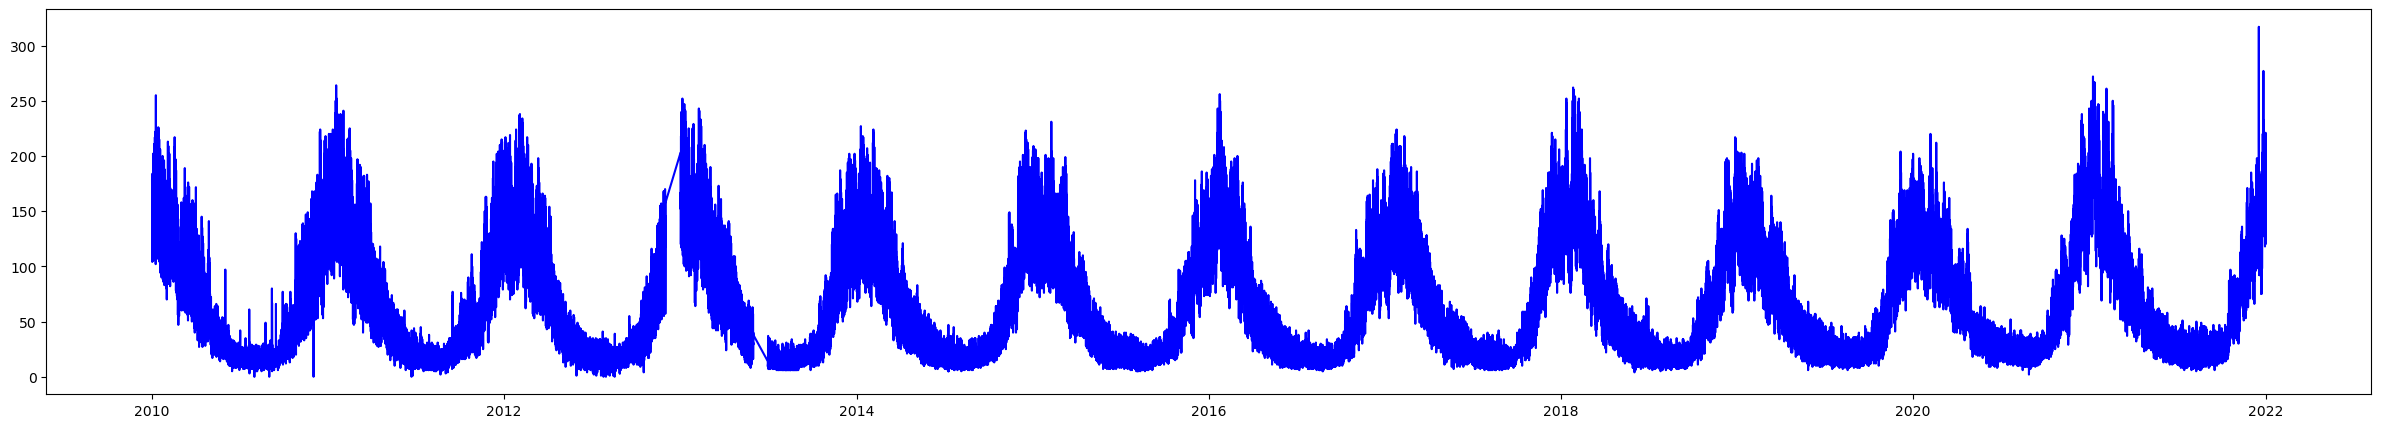

In [31]:
## 시각화
fig, ax1 = plt.subplots(figsize=(30,5))
ax1.plot(date, df_raw['CHEONGJU'], color='blue')
plt.show()

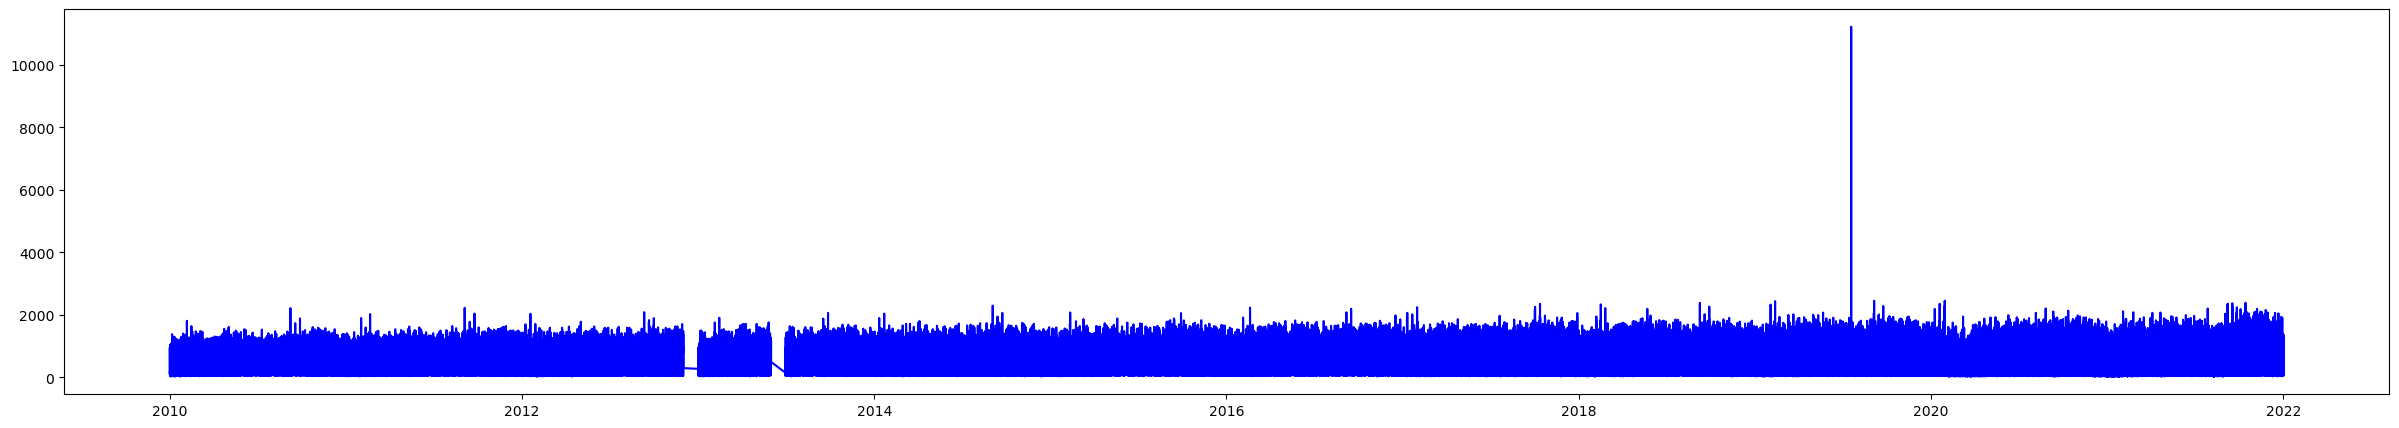

In [32]:
## 시각화
fig, ax1 = plt.subplots(figsize=(30,5))
ax1.plot(date, df_raw['TRAFFIC_IN_1'], color='blue')
plt.show()

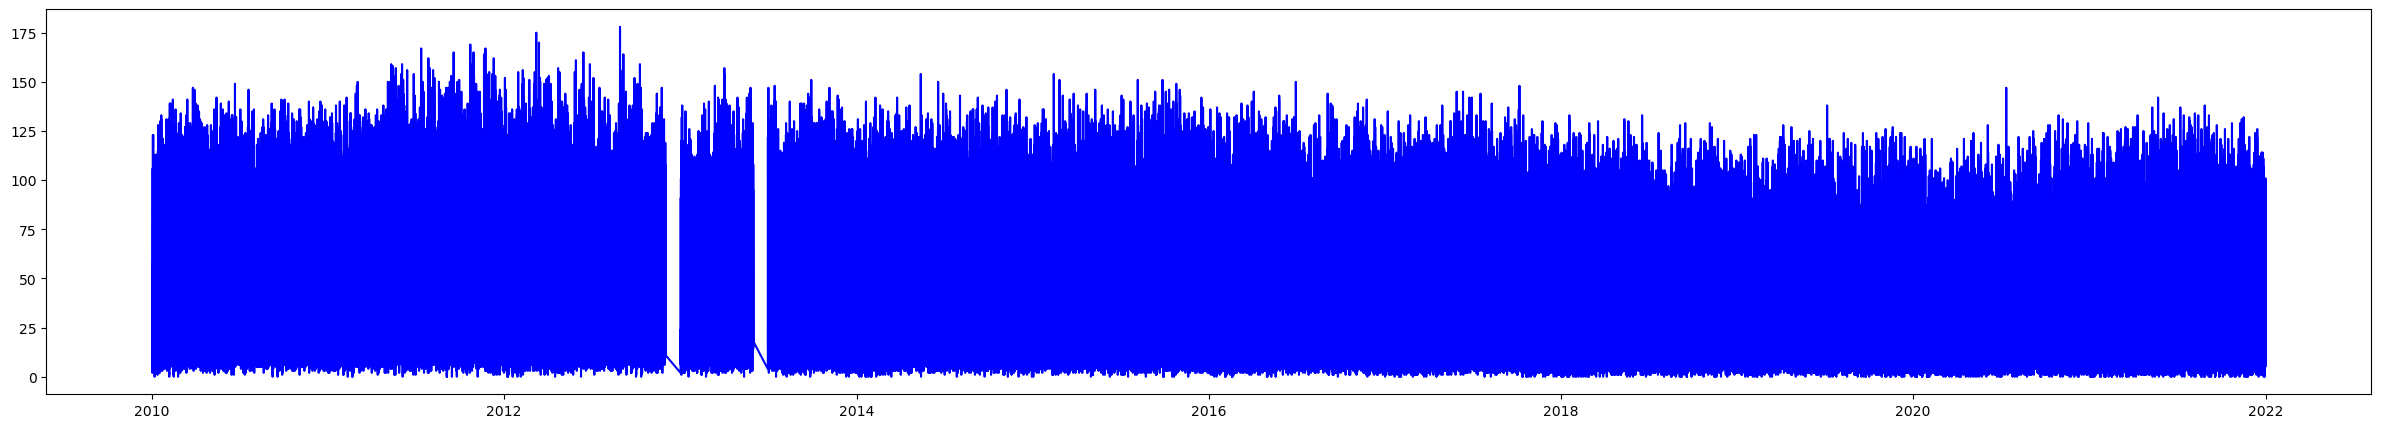

In [33]:
## 시각화
fig, ax1 = plt.subplots(figsize=(30,5))
ax1.plot(date, df_raw['TRAFFIC_IN_2'], color='blue')
plt.show()

In [34]:
df_raw_temp = df_raw

In [35]:
df_raw_temp.columns

Index(['METER_DATE', 'day_of_the_week', 'YEAR', 'MONTH', 'DAY', 'HOUR',
       'MINUTE', 'code_day_of_the_week', 'dist_from_holiday', 'rest_YN',
       'temp_outdoor', 'temp_dew_point', 'temp_ground', 'humidity', 'rainfall',
       'snowfall', 'snowfall_3hr', 'wind_speed', 'wind_direction',
       'pressure_vapor', 'pressure_area', 'pressure_sea', 'sunshine',
       'solar_radiation', 'cloud_total', 'cloud_midlow', 'visual_range',
       'CHEONGJU', 'TRAFFIC_IN_1', 'TRAFFIC_IN_2', 'TRAFFIC_OUT_1',
       'TRAFFIC_OUT_2', 'POPULATION_TOTAL', 'POPULATION_MALE',
       'POPULATION_FEMALE'],
      dtype='object')

In [36]:
## 1) Train 전 오류
## ValueError: DataFrame.dtypes for data must be int, float or bool.
## Did not expect the data types in the following fields: DHW_METER_DATE, day_of_the_week, name_of_holiday
## 형식에 맞지 않는 열이 앞의 Preprocessing 단계에서 제거되어야 함.
## 2) Train 중 오류
## ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type Timestamp).
## 1차 : METER_DATE / day_of_the_week / MINUTE 제외 전체 변수 사용
df_raw_temp = df_raw_temp[['YEAR', 'MONTH', 'DAY', 'code_day_of_the_week', 'dist_from_holiday', 'rest_YN'
                           , 'HOUR'
                           , 'temp_outdoor', 'temp_dew_point', 'temp_ground'
                           , 'humidity'
                           , 'rainfall', 'snowfall', 'snowfall_3hr'
                           , 'wind_speed', 'wind_direction'
                           , 'pressure_vapor', 'pressure_area', 'pressure_sea'
                           , 'sunshine'
                           , 'solar_radiation'
                           , 'cloud_total', 'cloud_midlow', 'visual_range'
                           , 'POPULATION_TOTAL', 'POPULATION_MALE', 'POPULATION_FEMALE'
                           , 'TRAFFIC_IN_1', 'TRAFFIC_IN_2', 'TRAFFIC_OUT_1', 'TRAFFIC_OUT_2'
                           , 'CHEONGJU']]

## 2차 YD, Dist 제거
# df_raw_temp['TRAFFIC_IN_TOTAL'] = df_raw_temp['TRAFFIC_IN_1'] + df_raw_temp['TRAFFIC_IN_2']
# df_raw_temp['TRAFFIC_OUT_TOTAL'] = df_raw_temp['TRAFFIC_OUT_1'] + df_raw_temp['TRAFFIC_OUT_2']
# df_raw_temp = df_raw_temp[['MONTH', 'code_day_of_the_week', 'dist_from_holiday', 'rest_YN'
#                            , 'HOUR'
#                            , 'temp_outdoor', 'temp_dew_point', 'temp_ground'
#                            , 'humidity'
#                            , 'rainfall', 'snowfall', 'snowfall_3hr'
#                            , 'wind_speed', 'wind_direction'
#                            , 'pressure_vapor', 'pressure_area', 'pressure_sea'
#                            , 'sunshine'
#                            , 'solar_radiation'
#                            , 'cloud_total', 'cloud_midlow', 'visual_range'
#                            , 'POPULATION_TOTAL'
#                            , 'TRAFFIC_IN_TOTAL', 'TRAFFIC_OUT_TOTAL'
#                            , 'CHEONGJU']]

## 3차 YD, Code_day_of_the_week 제거
# df_raw_temp['TRAFFIC_IN_TOTAL'] = df_raw_temp['TRAFFIC_IN_1'] + df_raw_temp['TRAFFIC_IN_2']
# df_raw_temp['TRAFFIC_OUT_TOTAL'] = df_raw_temp['TRAFFIC_OUT_1'] + df_raw_temp['TRAFFIC_OUT_2']
# df_raw_temp = df_raw_temp[['MONTH', 'rest_YN'
#                            , 'HOUR'
#                            , 'temp_outdoor', 'temp_dew_point', 'temp_ground'
#                            , 'humidity'
#                            , 'rainfall', 'snowfall'
#                            , 'wind_speed'
#                            , 'pressure_vapor', 'pressure_area', 'pressure_sea'
#                            , 'sunshine'
#                            , 'solar_radiation'
#                            , 'cloud_total', 'cloud_midlow', 'visual_range'
#                            , 'POPULATION_TOTAL'
#                            , 'TRAFFIC_IN_TOTAL', 'TRAFFIC_OUT_TOTAL'
#                            , 'CHEONGJU']]
df_raw_temp.isnull().sum()

YEAR                    0
MONTH                   0
DAY                     0
code_day_of_the_week    0
dist_from_holiday       0
rest_YN                 0
HOUR                    0
temp_outdoor            0
temp_dew_point          0
temp_ground             0
humidity                0
rainfall                0
snowfall                0
snowfall_3hr            0
wind_speed              0
wind_direction          0
pressure_vapor          0
pressure_area           0
pressure_sea            0
sunshine                0
solar_radiation         0
cloud_total             0
cloud_midlow            0
visual_range            0
POPULATION_TOTAL        0
POPULATION_MALE         0
POPULATION_FEMALE       0
TRAFFIC_IN_1            0
TRAFFIC_IN_2            0
TRAFFIC_OUT_1           0
TRAFFIC_OUT_2           0
CHEONGJU                0
dtype: int64

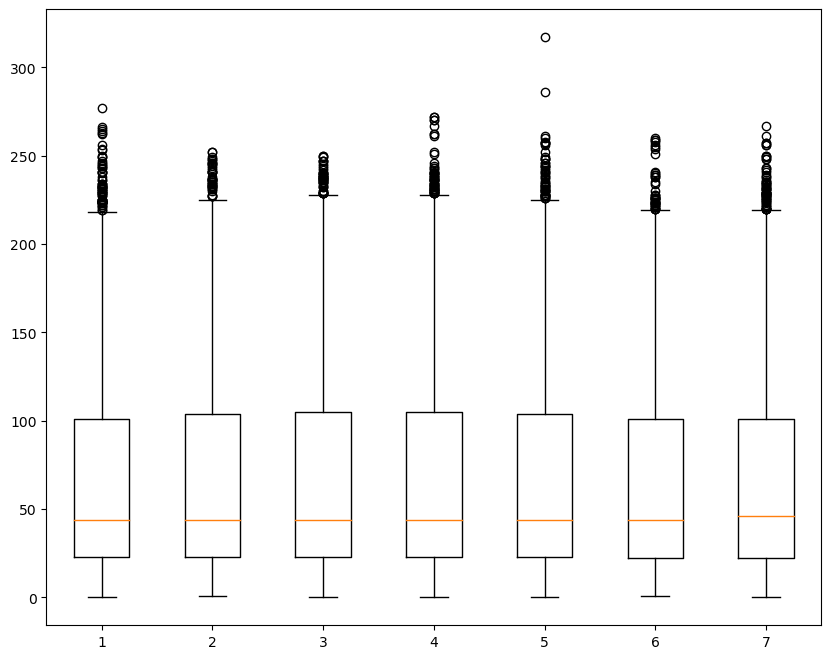

In [37]:
## 요일별 데이터 분리
## WD
df_traffic_0 = df_raw_temp[df_raw_temp['code_day_of_the_week'] == 0]
df_traffic_1 = df_raw_temp[df_raw_temp['code_day_of_the_week'] == 1]
df_traffic_2 = df_raw_temp[df_raw_temp['code_day_of_the_week'] == 2]
df_traffic_3 = df_raw_temp[df_raw_temp['code_day_of_the_week'] == 3]
df_traffic_4 = df_raw_temp[df_raw_temp['code_day_of_the_week'] == 4]
df_traffic_5 = df_raw_temp[df_raw_temp['code_day_of_the_week'] == 5]

## WE
df_traffic_6 = df_raw_temp[df_raw_temp['code_day_of_the_week'] == 6]
df_traffic_7 = df_raw_temp[df_raw_temp['code_day_of_the_week'] == 7]

plot_data = [df_traffic_0['CHEONGJU']
             , df_traffic_1['CHEONGJU']
             , df_traffic_2['CHEONGJU']
             , df_traffic_3['CHEONGJU']
             , df_traffic_4['CHEONGJU']
             , df_traffic_5['CHEONGJU']
             , df_traffic_6['CHEONGJU']]
ax = plt.boxplot(plot_data)
plt.show()

## 01-05. Data Split (By Weekdays)

In [38]:
df_WD = df_raw_temp[df_raw_temp['rest_YN'] == 0]
df_WD = df_WD.drop(columns = ['rest_YN'])

df_WE = df_raw_temp[df_raw_temp['rest_YN'] == 1]
df_WE = df_WE.drop(columns = ['rest_YN']) #, 'dist_from_holiday'

## 01-05. Data Analysis

### 01-05-01. Correlation

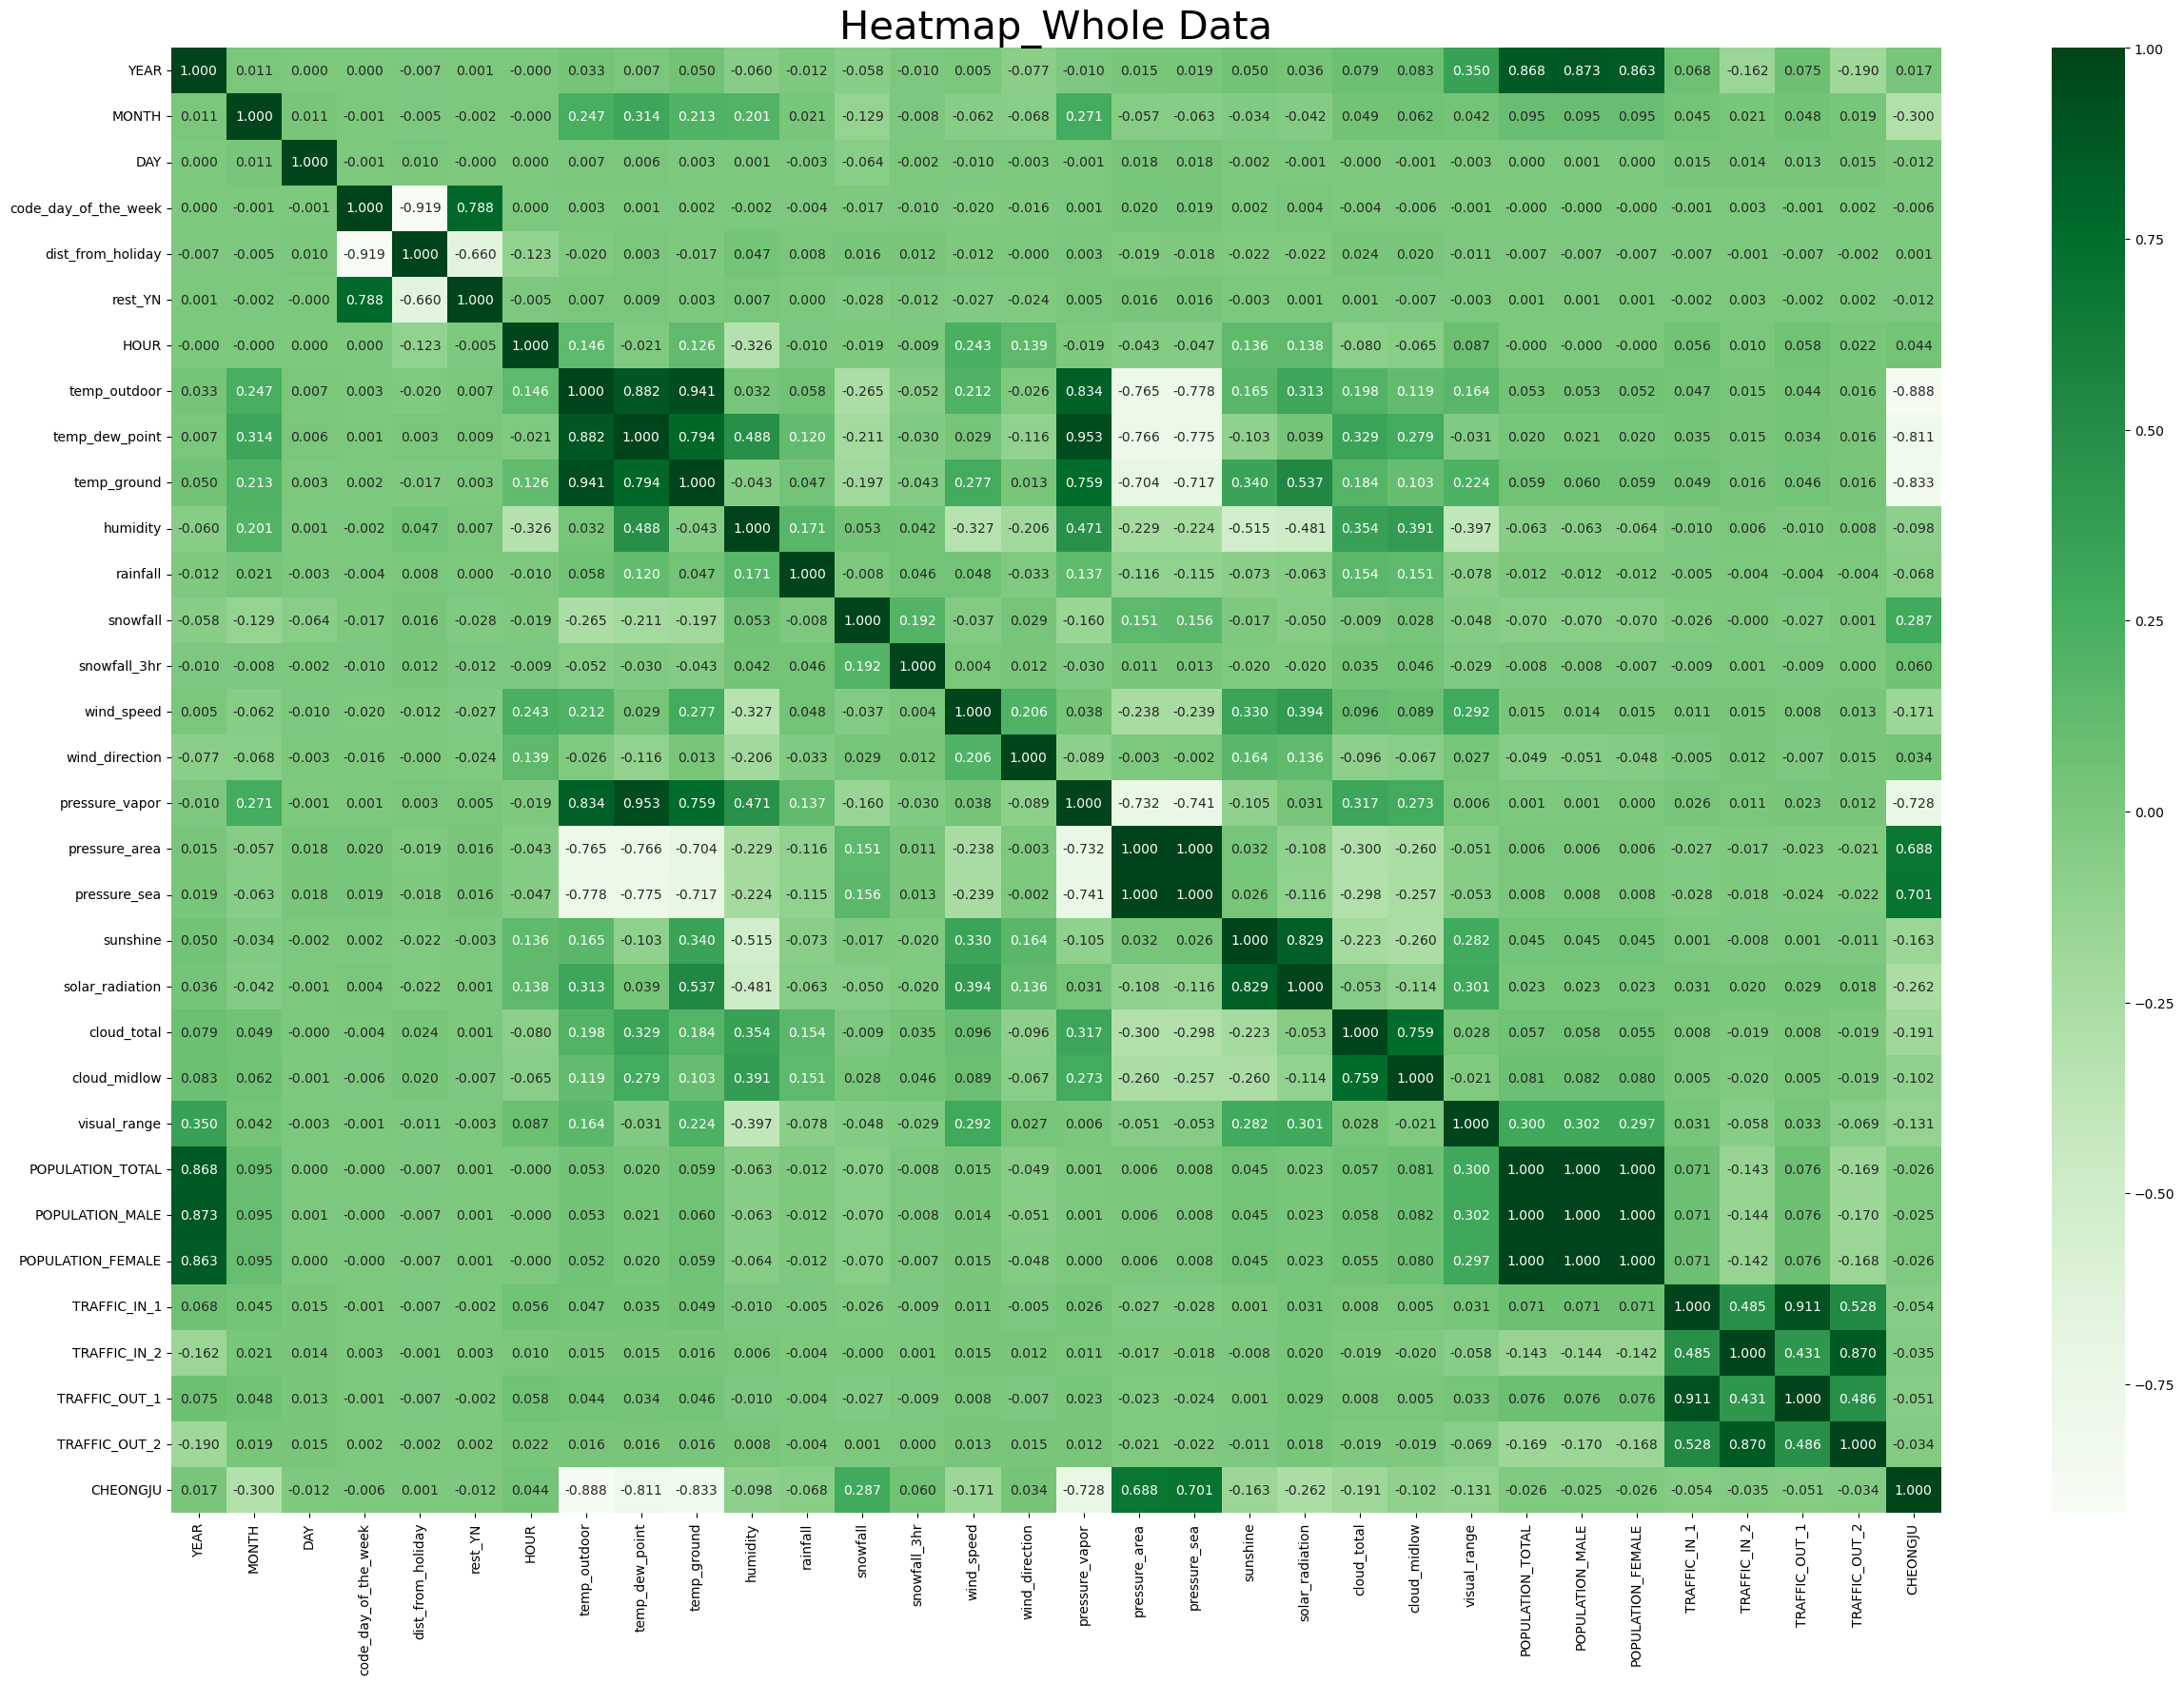

In [39]:
## 상관관계 분석
## 상관관계 변수 생성
df_corr = df_raw_temp.corr()
# df_corr.corr()

## Heatmap 분석
plt.figure(figsize=(30,20))
ax = sns.heatmap(df_corr, annot=True, fmt='.3f', cmap='Greens')
plt.title("Heatmap_Whole Data", fontsize=30)
plt.show()

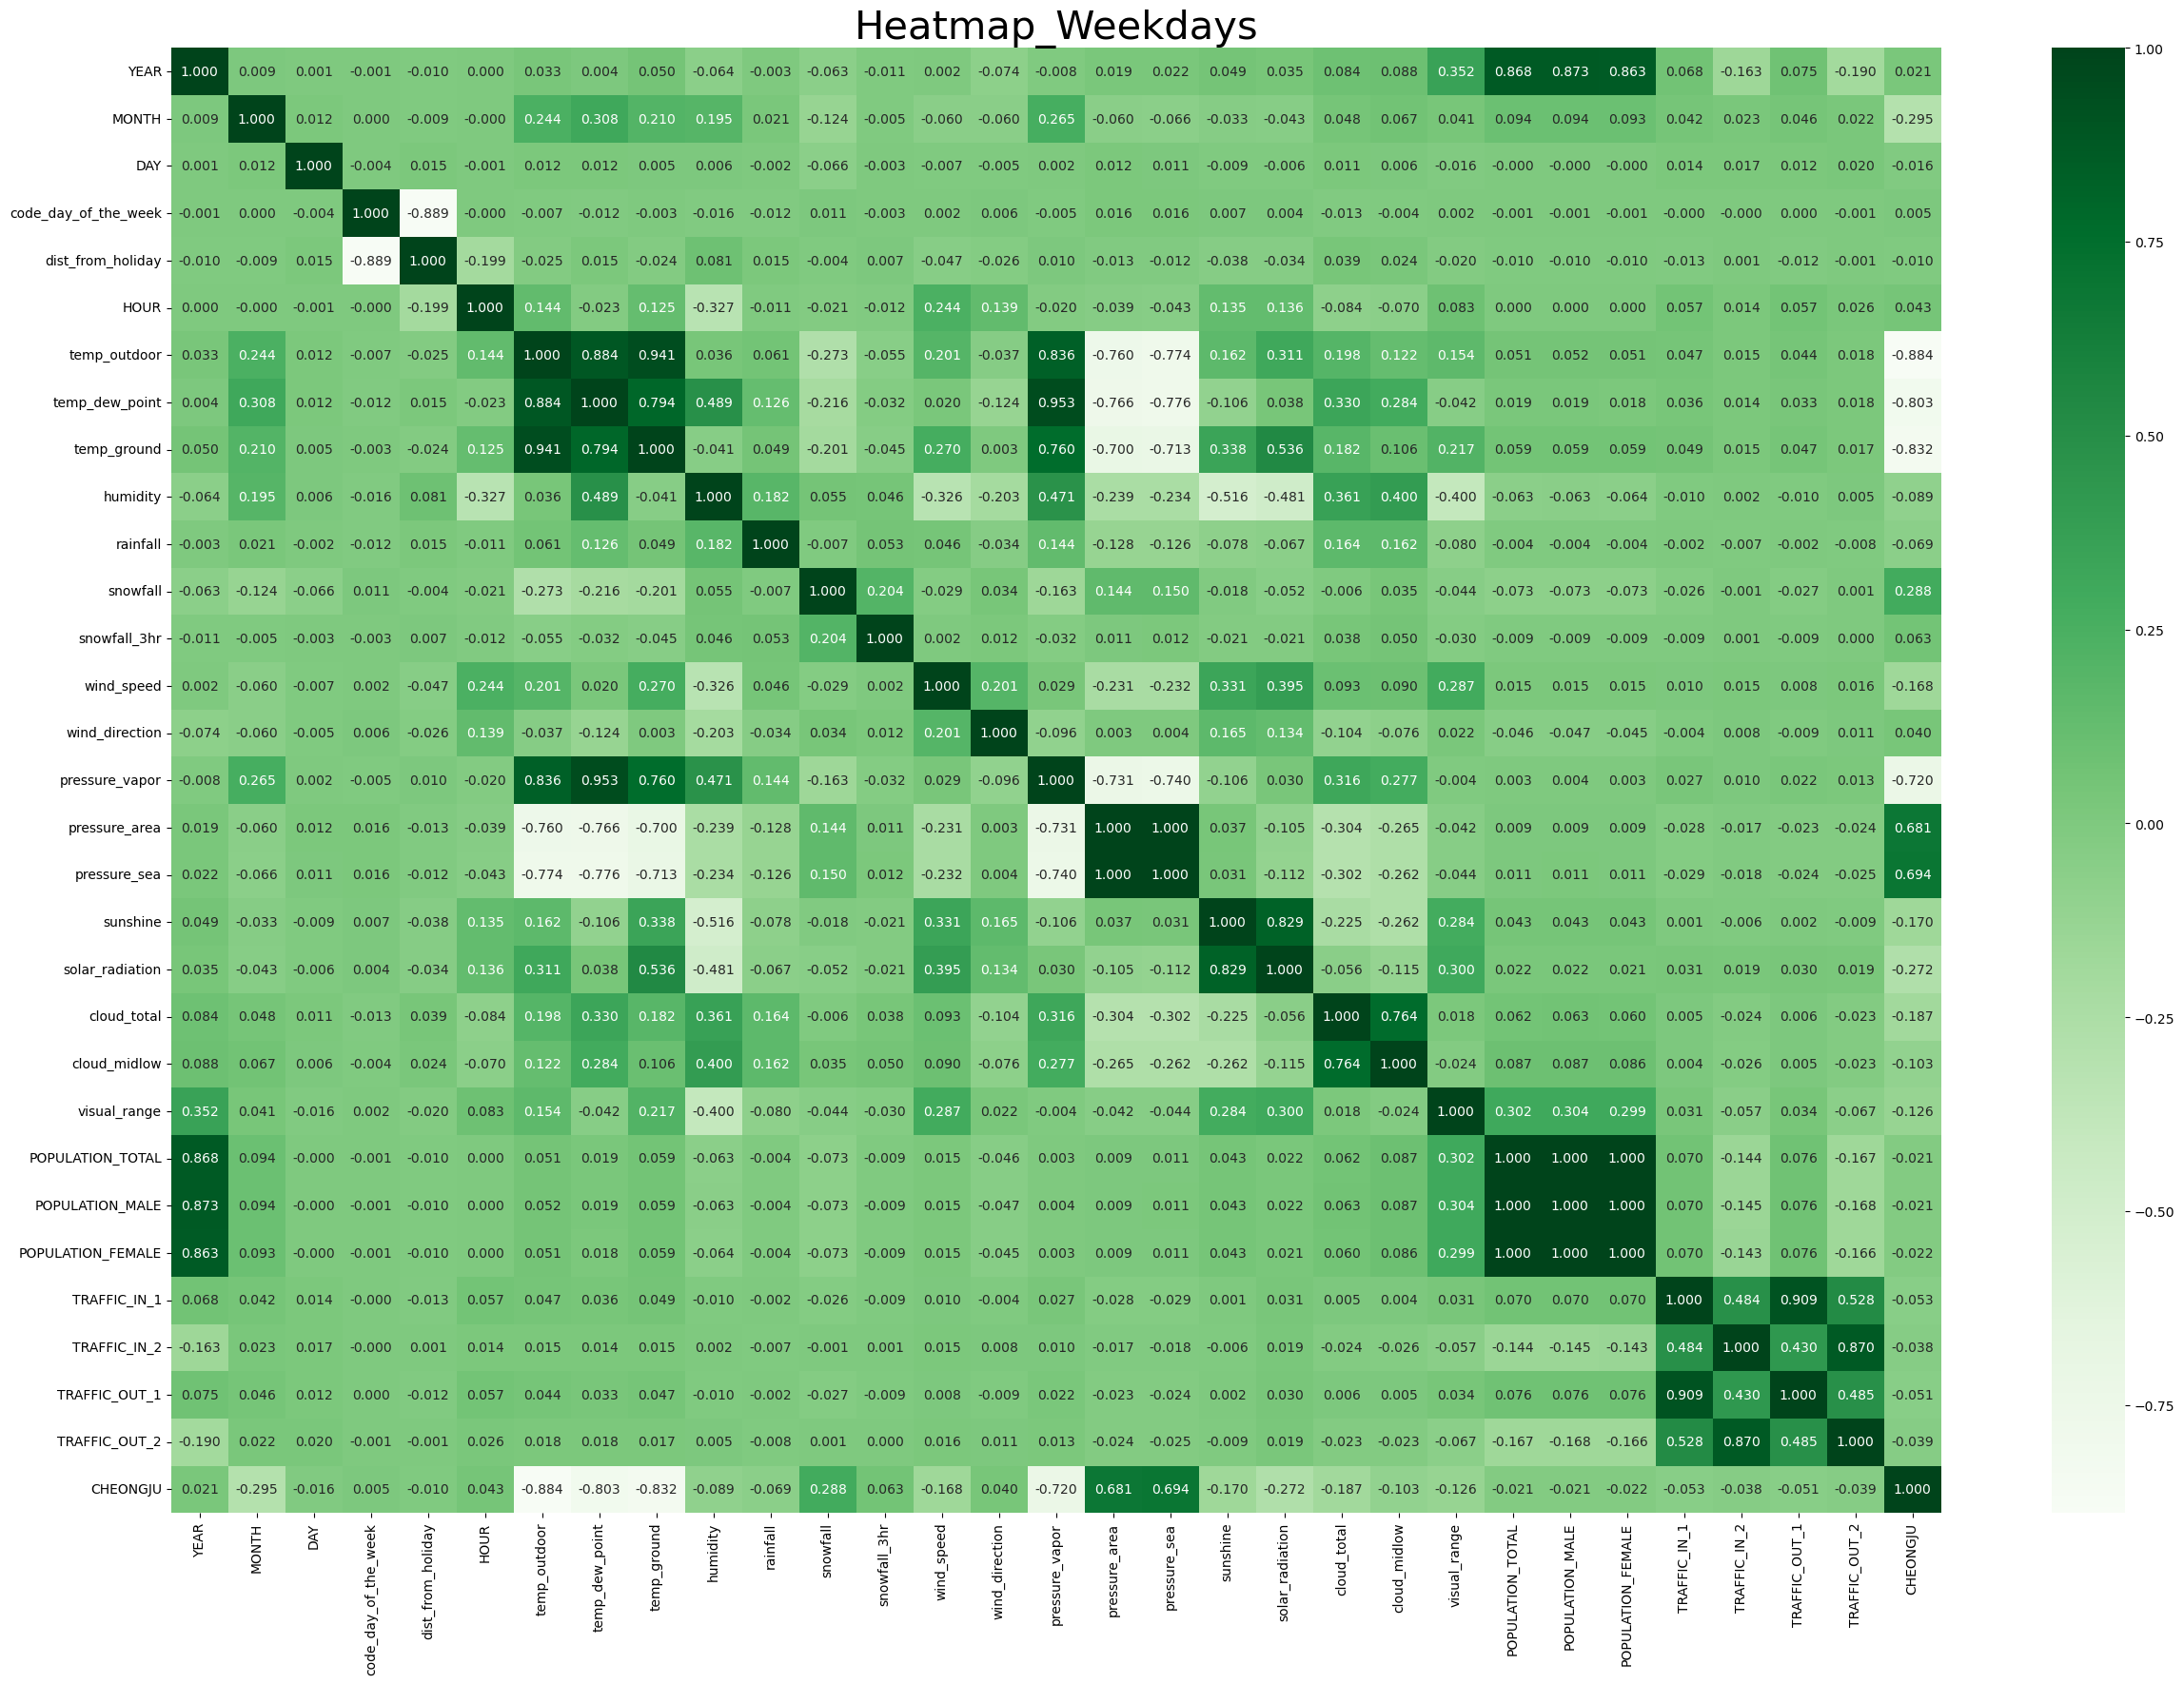

In [40]:
## 상관관계 분석
## 상관관계 변수 생성
df_corr = df_WD.corr()
# df_corr.corr()

## Heatmap 분석
plt.figure(figsize=(30,20))
ax = sns.heatmap(df_corr, annot=True, fmt='.3f', cmap='Greens')
plt.title("Heatmap_Weekdays", fontsize=30)
plt.show()

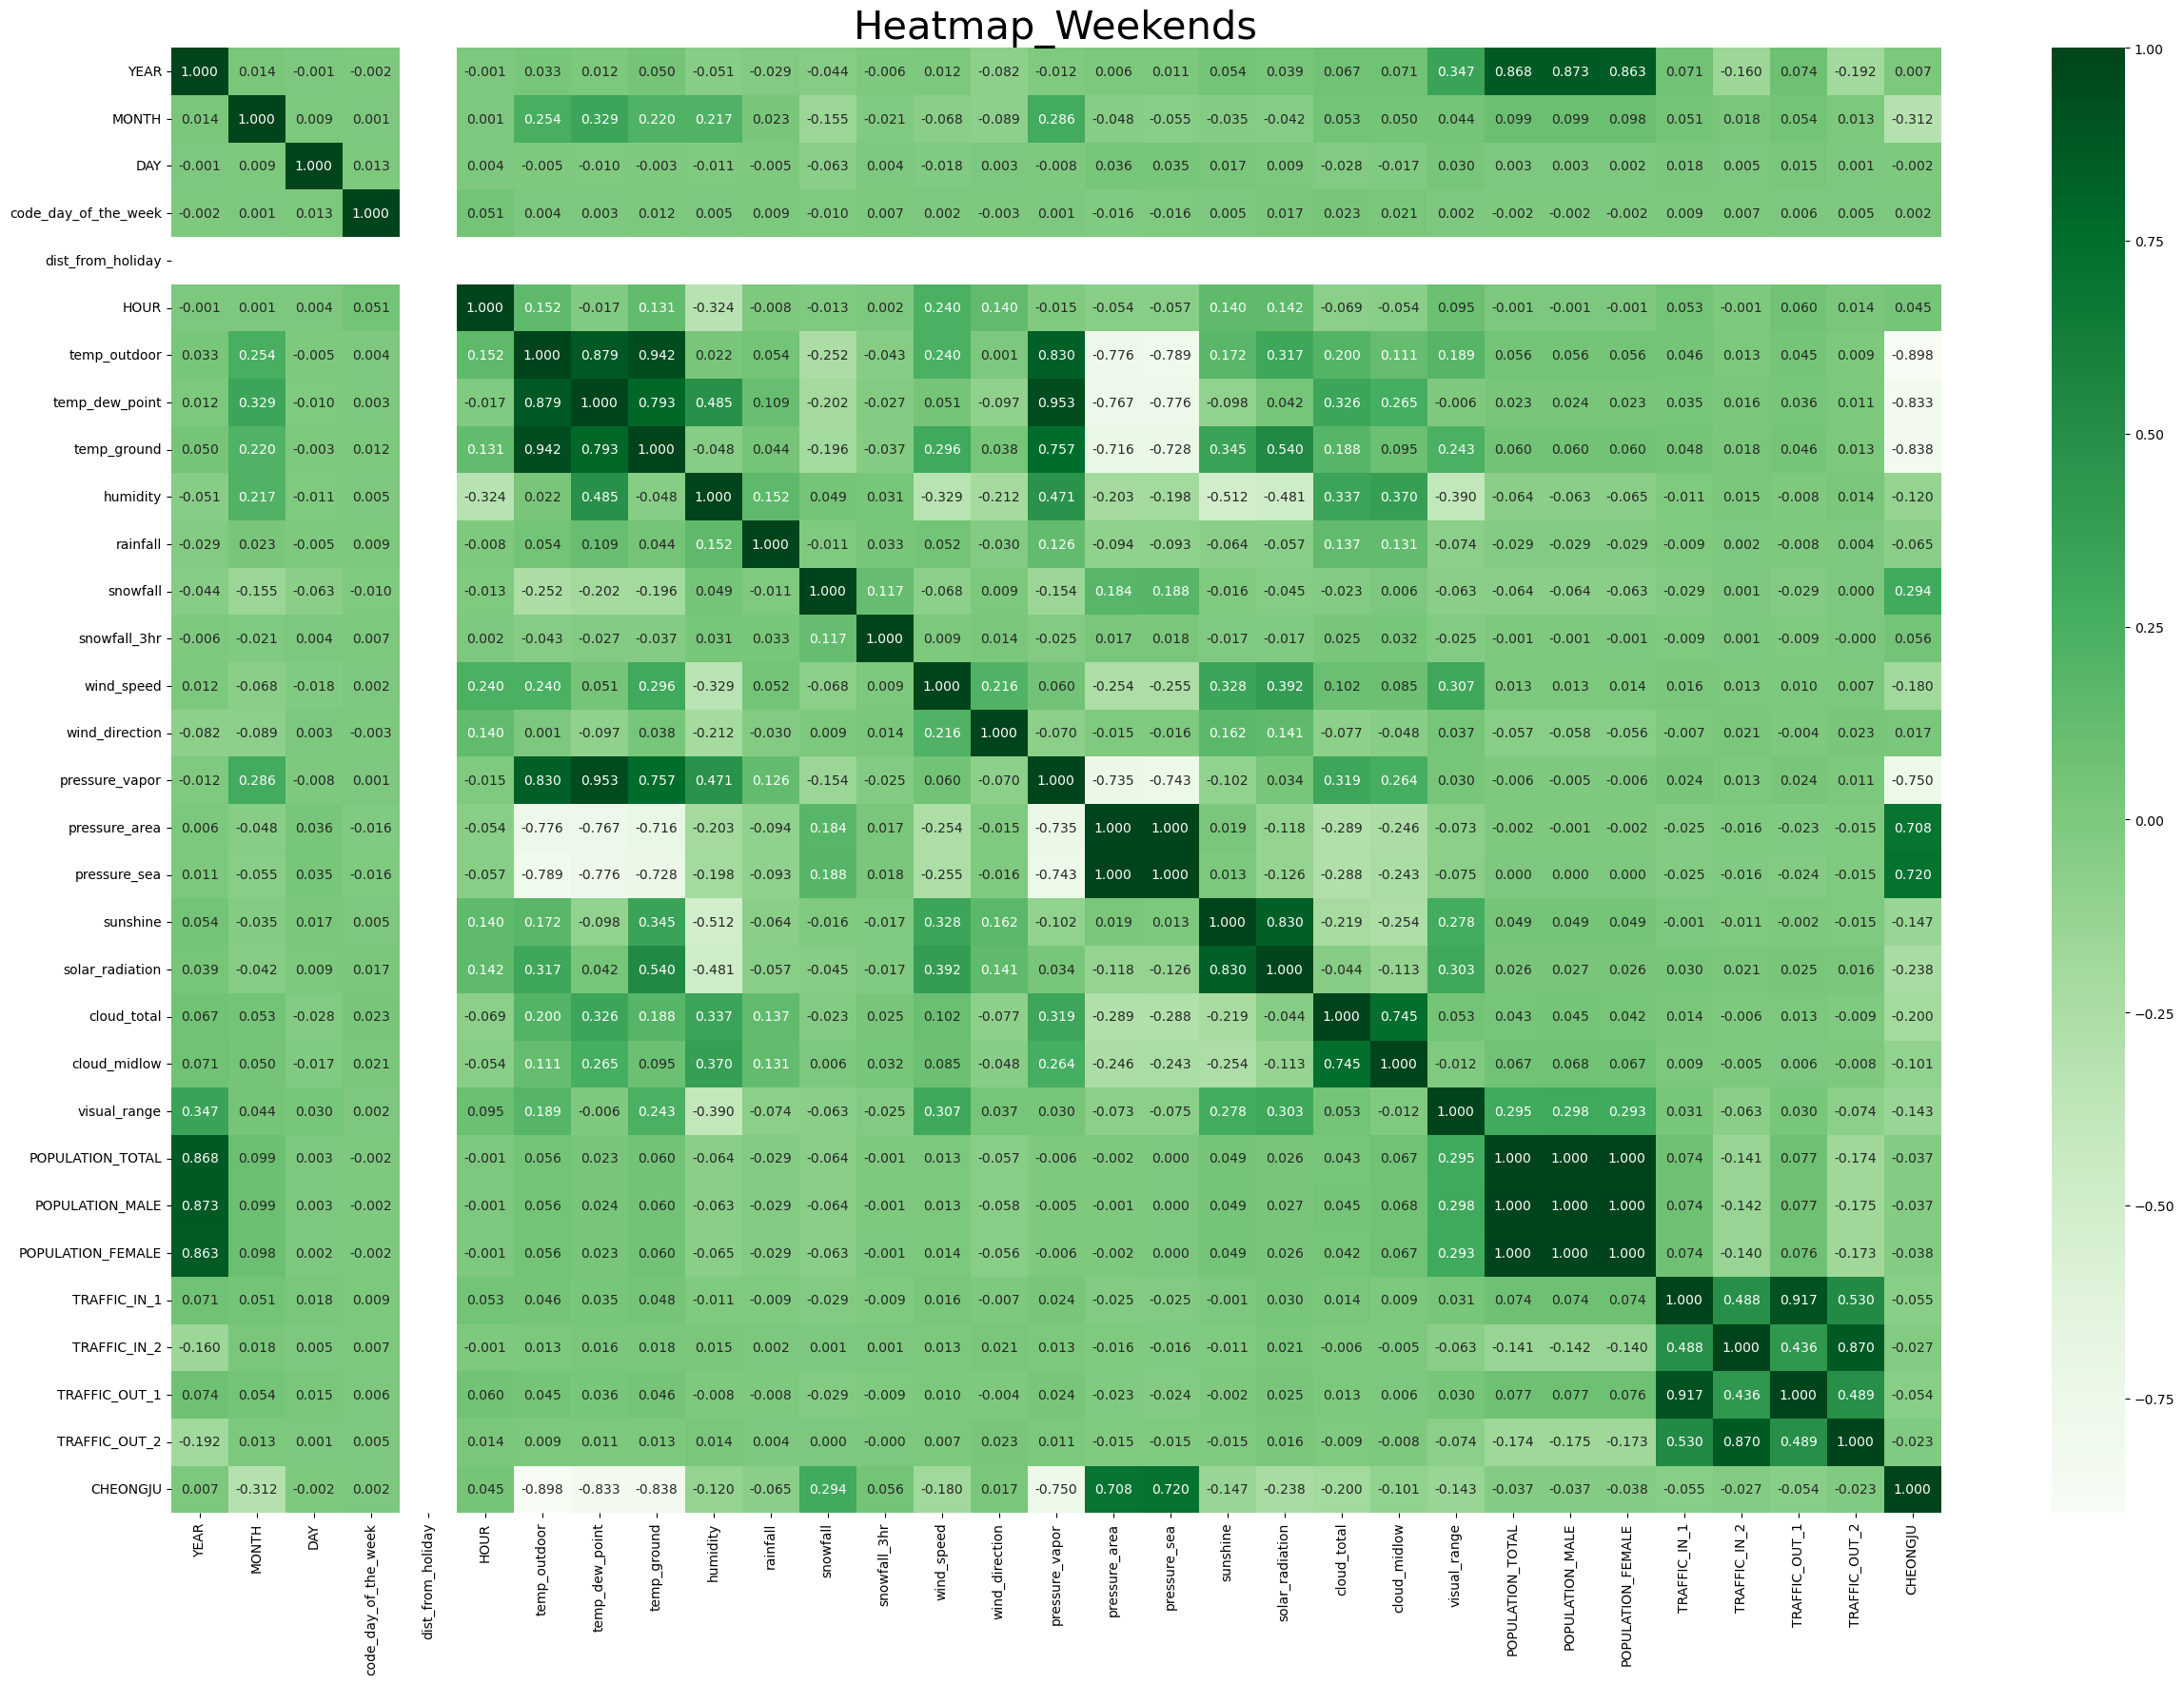

In [41]:
## 상관관계 분석
## 상관관계 변수 생성
df_corr = df_WE.corr()
# df_corr.corr()

## Heatmap 분석
plt.figure(figsize=(30,20))
ax = sns.heatmap(df_corr, annot=True, fmt='.3f', cmap='Greens')
plt.title("Heatmap_Weekends", fontsize=30)
plt.show()

## 01-06. Data Split (Train/Test Setting)

In [42]:
## 전체 유형
# df_raw = df_raw_temp
## 평일일 때만
df_raw = df_WD
## 휴일일 때만
# df_raw = df_WE

trainSet_Origin, testSet_Origin = train_test_split(df_raw, test_size=0.3, shuffle=False)
print(trainSet_Origin.shape, testSet_Origin.shape)

(51744, 31) (22176, 31)


In [43]:
trainSet = trainSet_Origin
testSet = testSet_Origin

## Input / Target Split
trainXX = trainSet.drop(['CHEONGJU'],axis=1)
trainYY = trainSet[['CHEONGJU']]
#valX = val.drop(['INST_F'],axis=1)
#valY = val[['INST_F']]
testXX = testSet.drop(['CHEONGJU'],axis=1)
testYY = testSet[['CHEONGJU']]

In [44]:
trainXXindex = trainXX.index
trainXXcolumns = trainXX.columns

trainYYindex = trainYY.index
trainYYcolumns = trainYY.columns

testXXindex = testXX.index
testXXcolumns = testXX.columns

testYYindex = testYY.index
testYYcolumns = testYY.columns

#valXindex = valX.index
#valYindex = valY.index

#valXcolumns = valX.columns
#valYcolumns = valY.columns

In [45]:
d_trainXX=pd.DataFrame(trainXX, index=trainXXindex, columns=trainXXcolumns)
# d_trainXX=pd.DataFrame(trainXX, index=trainXXindex, columns=trainXXcolumns)
d_trainYY=trainYY

#d_valX=pd.DataFrame(func_valSet, index=valXindex, columns=valXcolumns)
#d_valY=valY

d_testXX=pd.DataFrame(testXX, index=testXXindex, columns=testXXcolumns)
# d_testXX=pd.DataFrame(trainXX, index=testXXindex, columns=testXXcolumns)
d_testYY=testYY

## 01-07. ML (LGBM)


In [46]:
params = {
    'learning_rate': 0.01,
    'objective': 'regression',
    'metric':'mae',
    'seed':42
}

model = LGBMRegressor(n_estimators=10000, learning_rate=0.01, verbose=500) #10000

lgbm_model = model.fit(trainXX, trainYY, eval_metric='mae',eval_set=[(trainXX, trainYY)])

[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.887306
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.180755
[LightGBM] [Debug] init for col-wise cost 0.000815 seconds, init for row-wise cost 0.001309 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001741 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 3796
[LightGBM] [Info] Number of data points in the train set: 51744, number of used features: 30
[LightGBM] [Info] Start training from score 66.348620
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tr

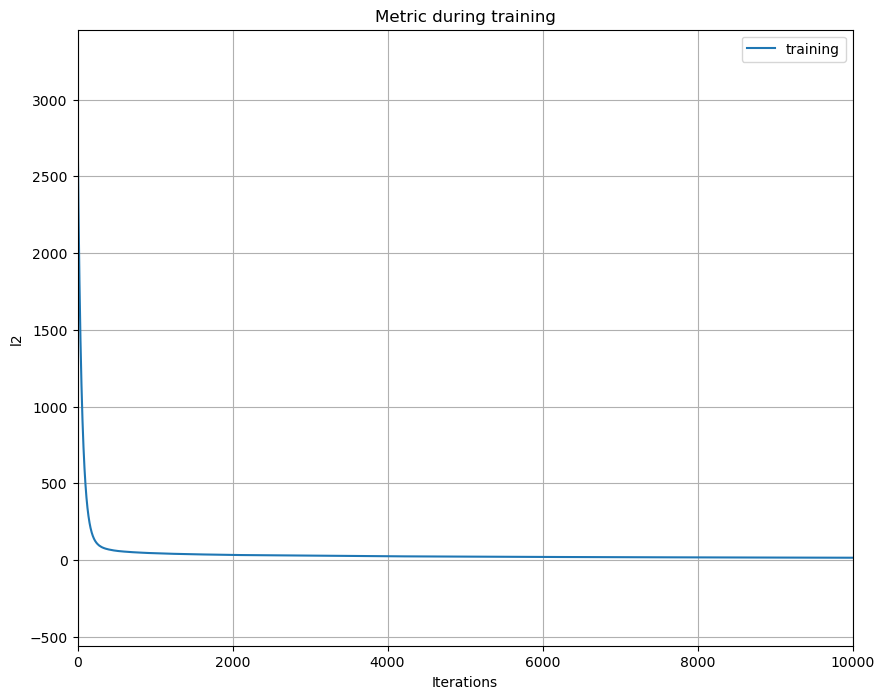

In [47]:
lgbm.plot_metric(lgbm_model)
plt.show()

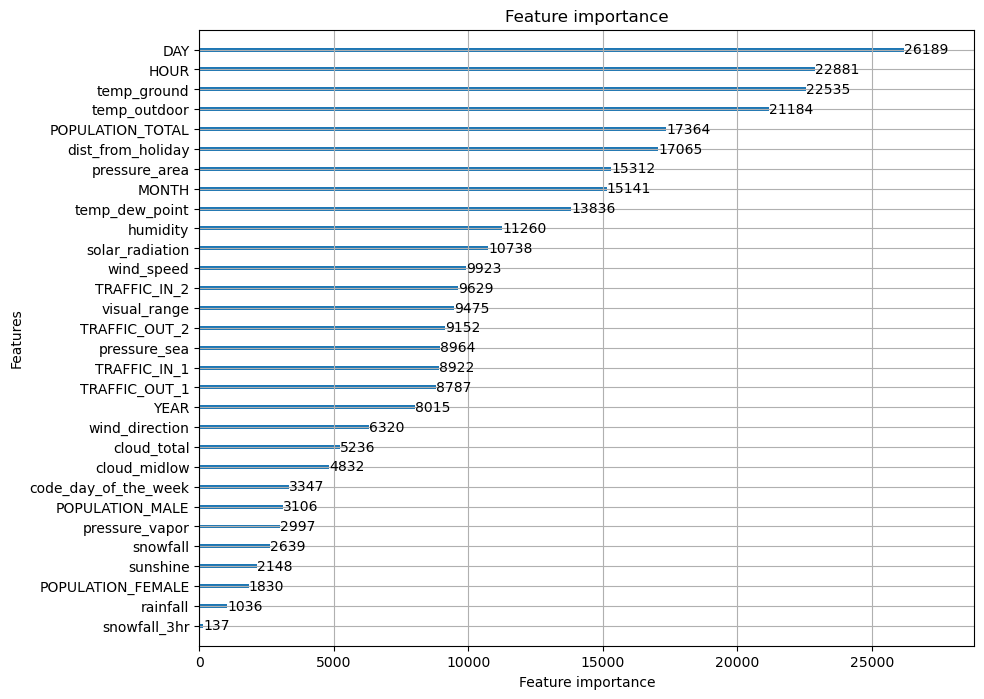

In [48]:
lgbm.plot_importance(lgbm_model)
plt.show()

In [49]:
model_pred = model.predict(testXX)
model_preds=np.reshape(model_pred,(-1,1))

d_actual = testYY.to_numpy()
d_actual = np.reshape(d_actual,(-1,1))

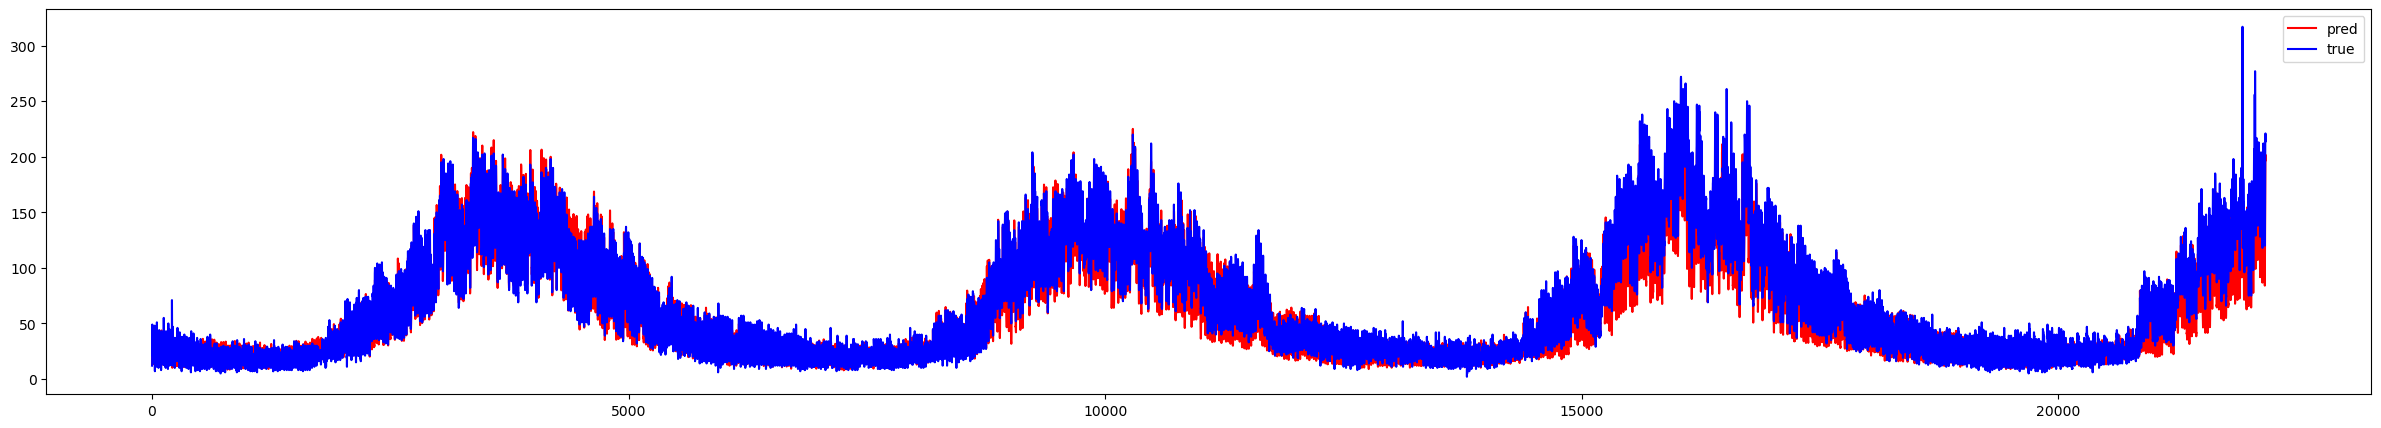

In [50]:
plt.figure(figsize=(30,5))
plt.plot(model_preds,color='red',label='pred')
plt.plot(d_actual,color='blue',label='true')
plt.legend()
plt.show()

In [51]:
from sklearn.metrics import mean_absolute_percentage_error
print('mean_absolute_percentage_error : ', mean_absolute_percentage_error(d_actual, model_preds))

from sklearn.metrics import mean_absolute_error
print('mean_absolute_error : ', mean_absolute_error(d_actual, model_preds))                                      

from sklearn.metrics import mean_squared_error
print('mean_squared_error : ', mean_squared_error(d_actual, model_preds))

from sklearn.metrics import r2_score   # model.score
print('r2_score : ', r2_score(d_actual, model_preds))

mean_absolute_percentage_error :  0.1431352394733139
mean_absolute_error :  7.775372425342396
mean_squared_error :  128.79050517393958
r2_score :  0.9521472966336924
